# Introduction

L'objectif du notebook est de concevoir un premier modèle de classification d'images. On va utliser une architecture lenet pour commencer. C'est CNN simple qui va nous permettre de nous faire une première idée de la contribution des différents facteurs (data, hyper-paramètres) à la performance de notre modèle.

Nos ressources de calul (et de temps) étant limitées, on va mener les comparaisons de la section 1 (surtout) et 2 sur un sous-ensemble des données,un nombre d'époques limitées et certains hyperparamètres restreints.

On va adopter la stratégie suivante:

1. Tenter d'abord de mesurer l'impact des différentes étapes de pre-processing sur nos modèles. Toutes choses égales par ailleurs, on va tester le même modèle avec dans l'ordre:
  1. Le dataset sans ré-équilibrage de classes et avec les images non zoomées
  2. Le dataset sans ré-équilibrage de classes et avec les images zoomées
  3. Le dataset avec ré-équilibrage de classes et avec les images zoomées
2. Enfin, après avoir trouvé le dataset le plus approprié, on va tester l'impact de différents hyper-paramètres sur la performance:
  1. Un learning rate plus élevé avec une stratégie de _learning rate decay__
  2. Un batch_size plus gros
  3. Une taille d'image plus grande
3. On va séléctionner le dataset et les hyper-paramètres les plus prometteurs des sections précédentes et entrainer le modèle de façon plus poussé sur un dataset complet et en restaurant les hyper-paramètres qu'on avait restreints par soucis d'économie de temps lors de nos comparaisons



# Initialisation

In [ ]:
import sys
import os

if 'google.colab' in sys.modules:
    from google.colab import drive
    if not os.path.exists('/content/drive'):
      drive.mount('/content/drive/')
    %cd drive/MyDrive/nov23_bds_rakuten
else:
    root_files = os.listdir()
    if not "requirements.txt" in root_files:
        print("The jupyter server root should be set to root of git project")
        print("If you're on vscode add the following to your settings.json file")
        print('"jupyter.notebookFileRoot": "${workspaceFolder}"')

Mounted at /content/drive/
/content/drive/.shortcut-targets-by-id/1_2JJeYhhAHn4xWGD5kC2VtjM-_SxznEm/nov23_bds_rakuten


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from pathlib import Path
import re
from tqdm import tqdm
import pickle as pickle

import zipfile

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score,classification_report

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback,EarlyStopping, LearningRateScheduler
from tensorflow.keras import backend as K
import keras.saving
from tensorflow.keras.regularizers import l1, l2

from keras.utils import to_categorical
from keras.models import load_model

random_state = 42
output_dir = "output/data-modeling-images-2"

# Librarie de fonctions

Bien que je préfère en général définir les fonctions au fur et à mesure de leur utilisation, la multiplication des stratégies que nous allons tester rend plus simple de les rassembler dans cette sections. En les extrayant du déroulement de chaque stratégie, nous pourrons plus efficacement dpuliquer et identifier leur trame commune.

## Import des données

Commençons par définir une fonction **import_images** qui permet d'importer le set d'images qu'on souhaite utiliser

In [ ]:
def import_images(zip_path,dest_dir):
    image_path = dest_dir
    image_dir = Path(image_path)
    if image_dir.exists():
        print("images already imported from drive")
    else:
        print("extracting images from drive into colab's session storage... (about 1 min)")
        with zipfile.ZipFile(zip_path,"r") as images_zip:
            images_zip.extractall(image_path)
    image_path = image_path + "/images"
    return image_path

## Rapport de modéle

Avant de commencer à créer notre modèle, nous allons nous occuper de comment on pourra comparer les différentes statégies que nous allons tester.

Nous allons créer un dataframe **df_reporting** qui contiendra les informations pertinentes sur notre stratégie de modélisation ainsi que ses resultats:
* Un nom et un id de modèle
* les sources de données utlisées ainsi que la taille du subset de données.
* Les hyper-paramètres du modèle
* L'état en cours de l'entrainement ainsi que nombre d'éqoques à atteindre
* Les métriques de performance de l'entrainement, la validation et des tests.

Au fur et à mesure de nos tests, on veillera à sauvegarder ce dataframe dans un fichier **model_reporting.csv**. Ce fichier nous assurera qu'on puisse reprendre nos tests là où ils se sont arretés en cas d'interruption. Dans ce cas, on veillera également à sauvegarder l'état des modèles ayant la meilleurs performance, afin de compléter l'entrainement sur les époques manquantes.

Plus tard, le fichier **model_reporting.csv** nous servira aussi à comparer les modéles de chaque notebook de modélisation. Pour cette raison, on va tenter d'être le plus complet possible dans les informations qu'on y met.

Ajoutons une fonction qui va créer le dataframe **df_reporting** en y ajoutant un modèles d'exemple

In [ ]:
def create_reporting_df(save=True):
  reporting_df = pd.DataFrame([{
      #model infos
      "model_id":int(0),
      "model_name":"Example model",

      #data sources
      "dataset_source": "output/data-exploration/X_train_pre.csv",
      "dataset_resampled": False,
      "image_dataset_source" : "data/images.zip",
      "image_dataset_zoomed" : False,
      "train_size": int(42458),

      #hyper parameters
      "image_size": int(300),
      "image_color_rgb": True,
      "batch_size":int(32),
      "image_data_generator_params": {"rescale":1./255,"shear_range":0.2,"zoom_range":0.2,"horizontal_flip":True},
      "start_lr": 0.001,
      "last_lr": 0.0001,
      "optimizer": "adam",

      #fit info
      "target_epochs": int(10),
      "last_epoch": int(6),
      "fit_complete": True,

      #metrics
      "f1_score": 0.42,
      "val_f1_score": 0.37,
      "test_f1_score": 0.35,
      "accuracy": 0.57,
      "val_accuracy": 0.39,
      "test_accuracy": 0.41,
      "loss": 1.567,
      "val_loss": 2.657,

      #other
      "remarks": "Ceci n'est pas un vrai modèle. C'est juste un exemple",
  }])

  reporting_df.set_index("model_id",inplace=True)
  if save:
    reporting_df.to_csv(output_dir+"/model_reporting.csv")
  return reporting_df




Ajoutons également une fonction qui va nous permettre de charger un **model_reporting_df** s'il existe

In [ ]:
def load_reporting_df():
  return pd.read_csv(output_dir+"/model_reporting.csv",index_col="model_id")

On a besoin d'une fonction pour ajouter une nouvelle ligne dans **reporting_df**

In [ ]:
def add_reporting_line(model_id:int,model_name:str,save:bool=True):
  reporting_df.loc[int(model_id),"model_name"] = str(model_name)
  if save:
    reporting_df.to_csv(output_dir+"/model_reporting.csv")

Ajoutons une fonction pour ajouter ou modifier des informations dans notre modèle. On veillera à ce que cette fonction sauvegarde automatiquement le dataframe dans **model_reporting.csv**. On a besoin de garder le maximum d'informations en cas d'interruption

In [ ]:
def update_reporting_line(model_id: int,d:dict={},save:bool=True):
  for key in d.keys():
        reporting_df.at[int(model_id), str(key)] = d.get(key)
  if save:
    reporting_df.to_csv(output_dir+"/model_reporting.csv")

Ajoutons une fonction **get_reporting_value** qui permette de récupérer une information stockée pour un modèle

In [ ]:
def get_reporting_value(model_id,key,default=None):
  try:
    value = reporting_df.at[model_id,key]
    if np.isnan(value):
      value=None
  except KeyError:
    value=None

  if value == None and default != None:
      value=default
  return value

## Création du modèle

Ajoutons une fonction **build_model** qui va nous permettre de créer les différentes couches de notre architecture lenet.

In [ ]:
def build_model():
    resnet_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Ajouter des couches supplémentaires pour l'adaptation au problème de classification
    x = GlobalAveragePooling2D()(resnet_model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)

    # Couche de sortie avec le nombre de classes dans votre ensemble de données (27 classes)
    output_layer = Dense(27, activation='sigmoid')(x)

    # Créer un nouveau modèle en spécifiant les entrées et la sortie
    custom_model = Model(inputs=resnet_model.input, outputs=output_layer)

    # Visualiser la structure du modèle
    custom_model.summary()

    return custom_model

Nous allons également avoir besoin d'un metric personnalisé **w_f1_score** qui permette de calculer le f1_score weighted.
On veille à ajouter l'annotation **@keras.saving.register_keras_serializable** pour que keras ne pose pas de problème lors du chargement du modèle

In [ ]:
def f1_score_sklearn(y_true, y_pred):
    y_true_classes = np.argmax(y_true, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    return f1_score(y_true_classes, y_pred_classes, average='weighted')

@keras.saving.register_keras_serializable(name='w_f1_score')
def w_f1_score(y_true, y_pred):
    f1 = tf.py_function(f1_score_sklearn, (y_true, y_pred), tf.float64)
    return f1

## Sauvegarde du modèle

Toujours en vue d'être résilient par rapport aux interruptions qui ont lieu régulierement lors de la phase d'entrainement du modèle, créons des fonctions qui vont nous permettre de sauvgarder et restaurer un modèle keras, afin de pouvoir reprendre l'entrainement s'il a été stoppé, ou même d'afficher les metrics d'un modèle dont l'entrainement est complet.

In [ ]:
def load_saved_model(model_id):
  model_path = output_dir+("/model-%d.keras" % model_id)
  model_path_obj = Path(model_path)
  if model_path_obj.exists():
    print("Load previous model from",model_path)
    return load_model(model_path)
  else:
    print("No previous model found at",model_path)
    return None

In [ ]:
def save_model(model_id,model):
  path = output_dir+("/model-%d.keras" % model_id)
  print("save model ",model_id,"to ",path)
  model.save(path)

Comme nous allons afficher des graphiques sur l'évolution des métriques pendant l'entrainement, il nous faut également des fonctions qui nous permettent de sauver, charger un historique

In [ ]:
def load_training_history(model_id):
  path = output_dir+("/training_history_%d.pkl" % model_id)
  history = None
  if Path(path).exists():
    with open(path, "rb") as file:
      history = pickle.load(file)
  return history

In [ ]:
def save_training_history(model_id,history):
  path = output_dir+("/training_history_%d.pkl" % model_id)
  with open(path, "wb") as file:
    pickle.dump(history,file)

Parcequ'un entrainemnt peut être fait en plusieurs fois, nous devons pouvoir concaténer un historique d'entrainement actuel avec le précédent sauvegardé.

In [ ]:
def concat_training_histories(prev_history,actual_history):
  full_history = {}
  for key in actual_history:
    full_history[key]=np.concatenate((prev_history[key],actual_history[key]),axis=0)
  return full_history

In [ ]:
def get_full_training_history(model_id,training_history):
  if training_history == None:
    history = load_training_history(model_id)
  else:
    prev_history = load_training_history(model_id)
    if prev_history != None:
      history = concat_training_histories(prev_history,training_history.history)
    else:
      history = training_history.history
  return history

## Callbacks pour l'entrainement du modèles

la callback **LogBest** va nous pemettre de sauvegarder l'état de l'entrainement et les métriques du modèle à la fin de chaque époque.

Seules les meilleurs metriques ne sont sauvegardées. Elles correspondent à la meilleure époque du modèle que nous sauvegardons également. Ils sont donc mis à jour au fur et à mesure de l'entrainement

In [ ]:
class LogBest(Callback):
    def __init__(self, model_id):
        super().__init__()
        self.model_id = model_id

    def on_epoch_end(self, epoch, logs=None):

        update_reporting_line(self.model_id,{
            'last_epoch': epoch +1, # Epochs are 0-indexed, so we add 1
            'last_lr': float(K.get_value(self.model.optimizer.learning_rate)),
        })

        if float(logs['val_w_f1_score']) <= float(get_reporting_value(self.model_id,"val_f1_score",0.0)):
          return
        print("\nFound better model with val_f1_score=%.2f" % float(logs['val_w_f1_score']))
        update_reporting_line(self.model_id,{
            "f1_score": logs['w_f1_score'],
            "val_f1_score": logs['val_w_f1_score'],
            "accuracy": logs['accuracy'],
            "val_accuracy": logs['val_accuracy'],
            "loss": logs['loss'],
            "val_loss": logs['val_loss'],
        })
        save_model(self.model_id,self.model)


Cette callback nous permet de stopper l'entrainement lorsque le f1 score ne progresse plus.

In [ ]:
early_stopping = EarlyStopping(
              monitor='val_w_f1_score',
              mode="max", #stop when f1 score is not increasing anymore
              patience=3,           # Number of epochs with no improvement
              min_delta=1e-2,       # Minimum change to qualify as an improvement
)

## Evaluation du modèle

Ajoutons quelques fonctions qui vont nous faciliter l'affichage de graphiques et de matrices lors de la phase d'évaluation du modèle

La fonction **plot_training_history** permet d'afficher l'évolution des différentes métriques en suivant le cours des époques de la phase d'entrainement

In [ ]:
def plot_training_history(history):
  x = range(1,len(history['accuracy']) + 1 )
  plt.figure(figsize=(12,5))
  plt.subplot(121)
  plt.plot(x,history['val_accuracy'],label="val_accuracy")
  plt.plot(x,history['accuracy'],label="accuracy")
  plt.plot(x,history['val_w_f1_score'],label="val_f1_score")
  plt.plot(x,history['w_f1_score'],label="f1_score")
  plt.xticks(x)
  plt.xlabel("Epoch")
  plt.ylabel("Score")
  plt.title("Accuracy/f1 evolution during training")
  plt.legend()

  plt.subplot(122)
  plt.plot(x,history['val_loss'],label="val_loss")
  plt.plot(x,history['loss'],label="loss")
  plt.xticks(x)
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Loss evolution during training")
  plt.legend()

  plt.show()


In [ ]:
prdcodetype2label = {
    10 : "Livre occasion",
    40 : "Jeu vidéo, accessoire tech",
    50 : "Accessoire Console",
    60 : "Console de jeu",
    1140 : "Figurine",
    1160 : "Carte Collection",
    1180 : "Jeu Plateau",
    1280 : "Jouet enfant,déguisement",
    1281 : "Jeu société",
    1300 : "Jouet tech",
    1301 : "Jeu intérieur,chaussettes",
    1302 : "Jeu extérieur,vêtement",
    1320 : "Bébé",
    1560 : "Mobilier intérieur",
    1920 : "Chambre",
    1940 : "Cuisine",
    2060 : "Décoration intérieure",
    2220 : "Animal",
    2280 : "Revues,journaux",
    2403 : "Magazines,livres,BDs",
    2462 : "Jeu occasion",
    2522 : "Bureautique,papeterie",
    2582 : "Mobilier extérieur",
    2583 : "Piscine",
    2585 : "Bricolage",
    2705 : "Livre neuf",
    2905 : "Jeu PC",
}

Enfin ajoutons une fonction **plot_confusion_matrix** qui nous permette d'afficher la matrice de confusion d'une façon qui soit lisible

In [ ]:
def plot_confusion_matrix(cm):
  plt.figure(figsize=(15, 8))
  sns.set(font_scale=0.8)
  classes = [(str(c) +": "+ prdcodetype2label[int(c)]) for c in classes_keras]
  sns.heatmap(cm, annot=True, cbar=True, square=False,fmt='g', cmap='Blues'
              ,xticklabels=classes,yticklabels=classes)
  plt.xlabel('Prédit')
  plt.ylabel('Réel')
  plt.title('Matrice de confusion')
  plt.show()

# Modélisation 1.1

On va maintenant tester les paramètres du même modèle mais en utilisant cette fois les images zoomées et un dataset avec des classes ré-équilibrées. Tous les autres paramètres restent identiques

Changeons la variables **model_id** pour qu'elle corresponde au modèle en cours

In [ ]:
model_id = 1111

## Import des données

On importe donc les images zoomées qui ont été produites par le notebook **data_preprocessing_images**

In [ ]:
image_path = import_images("output/data-preprocessing-images/images_pre.zip","/tmp/rakuten-images-2")

extracting images from drive into colab's session storage... (about 1 min)


On charge maintenant le csv des données ré-équilibrées par le notebook **data_preprocessing_resampling**. Ce notebook étant executé à partir des données en sortie de **data_preprocessing_images**, il contient également la colonne **imagefile**.

Nous n'aurons pas besoin de refaire le split des données d'entrainement, **data_preprocessing_resampling** s'en étant déjà chargé. Nous avons juste à charger les trois fichiers qui constituent sa sortie:
* **df_train.csv**: L'ensemble d'entrainement
* **df_val.csv**: L'ensemble de validation
* **df_test.csv**: L'ensemble de test

In [ ]:
df_train = pd.read_csv("output/data-preprocessing-resampling/df_train.csv", index_col=0)
df_val = pd.read_csv("output/data-preprocessing-resampling/df_val.csv")
df_test = pd.read_csv("output/data-preprocessing-resampling/df_test.csv")
df_val.head()

,index,productid,imageid,text,lang,text_fr,imagefile,prdtypecode
0,64448,1951685748,1317996370,Linxor - Bâche à Bulles 300 microns Piscine 3m...,fr,Linxor - Bâche à Bulles 300 microns Piscine 3m...,2583/image_1317996370_product_1951685748.jpg,2583
1,37973,159494381,1029666610,Kit piscine autoportante Easy Set Ø 305 x 076m -,fr,Kit piscine autoportante Easy Set Ø 305 x 076m -,2583/image_1029666610_product_159494381.jpg,2583
2,73967,4011564183,1276163958,Kayak Gonflable Betta Hm K0 Biplace Et Ses Acc...,fr,Kayak Gonflable Betta Hm K0 Biplace Et Ses Acc...,1302/image_1276163958_product_4011564183.jpg,1302
3,33180,3797074222,1246071438,Mini Coloré En Plastique Pot De Fleurs Succule...,fr,Mini Coloré En Plastique Pot De Fleurs Succule...,2582/image_1246071438_product_3797074222.jpg,2582
4,26659,4157458648,1303079928,Modèle De Voiturerc Buggy Truck Chassis Body L...,fr,Modèle De Voiturerc Buggy Truck Chassis Body L...,1300/image_1303079928_product_4157458648.jpg,1300


## Preprocessing

Cette fois-ci, on va se contenter de créer les variables **X** et **y** correspondant aux différents ensembles, puis on va réduire leur nombre d'observations pour qu'il soit similaire à ce qu'on a utilisé pour les premières modélisations

In [ ]:
X_train = df_train.drop("prdtypecode",axis=1)
y_train = df_train["prdtypecode"]

X_validation = df_val.drop("prdtypecode",axis=1)
y_validation = df_val["prdtypecode"]

X_test = df_test.drop("prdtypecode",axis=1)
y_test = df_test["prdtypecode"]

On réduit l'ensemble d'entrainement pour qu'il contienne environ 50% des données de départ. le paramètre stratify étant égal à **y_train**, le nombre d'occurences de chaque classe en sortie devrait être équilibré

In [ ]:
target_train_size = int(len(X_train) * 0.20)
print("Target train size is", target_train_size)
train_split_rate = (len(X_train) - target_train_size) / len(X_train)
X_train, X_none, y_train, y_none = train_test_split(X_train,y_train,test_size=train_split_rate,random_state = random_state,
                                                    shuffle=True,stratify=y_train)
print("X_train length is now",len(X_train))

Target train size is 21913
X_train length is now 21913


Confirmons que les classes sont toujours équilibrées après la réduction.

In [ ]:
y_train.value_counts()

1160    812
1940    812
2060    812
2582    812
2220    812
50      812
1560    812
40      812
1300    812
1281    812
2585    812
1140    812
1320    812
2522    812
1302    812
10      812
2280    811
2705    811
1180    811
1301    811
1920    811
2403    811
60      811
2583    811
2462    811
2905    811
1280    811
Name: prdtypecode, dtype: int64

C'est bien le cas

On va laisser les set de test et de validation inchangés car ils sont déjà calibré à 10% des données

## Initialisation du rapport de modéle

Si un fichier **model_reporting.csv** existe, on le charge. Autrement, on en crée un nouveau.

In [ ]:
Path(output_dir).mkdir(parents=True, exist_ok=True)
try:
  reporting_df = load_reporting_df()
  print("loaded ",output_dir+"/model_reporting.csv")
except FileNotFoundError:
  reporting_df = create_reporting_df()
  print(output_dir+"/model_reporting.csv","not found. creating one")


loaded  output/data-modeling-images-2/model_reporting.csv


In [ ]:
reporting_df.head()

,model_name,dataset_source,dataset_resampled,image_dataset_source,image_dataset_zoomed,train_size,image_size,image_color_rgb,batch_size,image_data_generator_params,...,fit_complete,f1_score,val_f1_score,test_f1_score,accuracy,val_accuracy,test_accuracy,loss,val_loss,remarks
model_id,,,,,,,,,,,,,,,,,,,,,
0,Example model,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,42458.0,300.0,True,32.0,"{'rescale': 0.00392156862745098, 'shear_range'...",...,True,0.420000,0.370000,0.350000,0.570000,0.390000,0.410000,1.567000,2.657000,Ceci n'est pas un vrai modèle. C'est juste un ...
112,Modèle 1.1.2,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,32869.0,224.0,True,32.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.223995,0.159299,0.153432,0.239699,0.169811,0.153432,2.552496,2.893241,NaN
111,Modèle 1.1.1,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,21913.0,224.0,True,64.0,"{'rescale': 0.00392156862745098, 'preprocessin...",...,True,0.491908,0.411804,0.416277,0.495126,0.402107,0.416277,1.654593,2.027163,NaN
113,Modèle 1.1.3,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,27391.0,224.0,True,64.0,"{'rescale': 0.00392156862745098, 'preprocessin...",...,True,0.329768,0.293019,0.290177,0.340872,0.307647,0.290177,2.190135,2.296956,NaN


Ajoutons une ligne correspondant à notre modèle et commençons à renseigner ses informations.

In [ ]:
add_reporting_line(model_id,"Modèle 1.1.1.1")

On peut déja renseigner les informations sur les données sources qu'on utilise

In [ ]:

update_reporting_line(model_id,{
    "dataset_source": "output/data-preprocessing-resampling/df_{train,val,test}.zip",
    "dataset_resampled": True,
    "image_dataset_source" : "output/data-preprocessing-images/images_pre.zip",
    "image_dataset_zoomed" : True,
    "train_size": len(X_train),
})

## Générateurs d'images

Commençons par créer une liste ordonnée des classes que l'on va fournir aux générateurs. Plus tard cette liste nous servira à retrouver les classes correspondant aux prédictions car la methode **predict** de keras retourne une matrice dont les colonnes correspondent aux classes dans l'ordre auquel on les a fourni.

In [ ]:
classes_keras = list(np.sort(np.array(df_train["prdtypecode"].unique(),dtype="str")))


On va reprendre ici les même générateurs d'image que pour la modélisation 1.1. On se contente de rappeler leur méthode **flow_from_dataframe** pour obtenir une instance adaptée au nouveau jeu de données.

On pense quand même à sauvegarder dans le rapport les paramètres de **ImageDataGenerator** pour le modèle en cours.

In [ ]:
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=5,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

update_reporting_line(model_id, {
    "image_data_generator_params" : {
      "rescale":1./255,
      'preprocessing_function':'preprocess_input',
      "rotation_range":20,
      "width_shift_range":0.1,
      "height_shift_range":0.1,
      "shear_range":5,
      "zoom_range":0.1,
      "horizontal_flip":True,
      "vertical_flip":True,
      "fill_mode":'nearest'
      }
})

batch_size = 64
target_img_size = (224,224,3)
color_mode = "rgb"

update_reporting_line(model_id, {
    "batch_size":batch_size,
    "image_size": target_img_size[0],
    "image_color_rgb": True
})

train_generator = train_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_train['imagefile'],"prdtypecode": y_train.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 21913 validated image filenames belonging to 27 classes.


In [ ]:
validation_data_generator = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input
)

validation_generator = validation_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_validation['imagefile'],"prdtypecode": y_validation.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 8492 validated image filenames belonging to 27 classes.


In [ ]:
test_data_generator = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input,
)

test_generator = test_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_test['imagefile'],"prdtypecode": y_test.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras,
    shuffle=False
)

Found 8492 validated image filenames belonging to 27 classes.


## Création du model

S'il n'y a pas encore de modèle enregistré, on le construit puis on le compile en veillant à passer notre métrique **w_f1_score** personnalisée.
On conserve le même taux d'apprentissage de départ que dans la modélisation 1.1

In [ ]:
# model = load_saved_model(model_id)
start_lr = 0.001
print("build model")
model = build_model()
model.compile(
    optimizer=Adam(learning_rate=start_lr),
    loss='categorical_crossentropy',
    metrics=['accuracy', w_f1_score]
)
update_reporting_line(model_id,{
    "start_lr": start_lr,
    "optimizer": "adam",
})

build model
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_5[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                            

## Entrainement du model

On procéde à l'entrainement du modèle de la même façon que lors de la modélisation 1.1. Là encore, on réutilise les mêmes paramètres.

In [ ]:
target_epochs = 10
if not get_reporting_value(model_id,"fit_complete",False):
  update_reporting_line(model_id,{
      "target_epochs": target_epochs
  })
  training_history = model.fit(
      train_generator,
      validation_data=validation_generator,
      steps_per_epoch=train_generator.samples // batch_size,
      validation_steps = validation_generator.samples // batch_size,
      epochs=target_epochs - int(get_reporting_value(model_id,"last_epoch",0)),
      verbose=1,
      callbacks=[LogBest(model_id),early_stopping]
  )
  update_reporting_line(model_id,{"fit_complete":True})
else:
  print("No need to train model")
  training_history = None

Epoch 1/10
342/342 [==============================] - ETA: 0s - loss: 2.6870 - accuracy: 0.2178 - w_f1_score: 0.1977
Found better model with val_f1_score=0.00
save model  1111 to  output/data-modeling-images-2/model-1111.keras
342/342 [==============================] - 486s 1s/step - loss: 2.6870 - accuracy: 0.2178 - w_f1_score: 0.1977 - val_loss: 4.6355 - val_accuracy: 0.0103 - val_w_f1_score: 0.0030
Epoch 2/10
342/342 [==============================] - ETA: 0s - loss: 2.3181 - accuracy: 0.3125 - w_f1_score: 0.2974
Found better model with val_f1_score=0.05
save model  1111 to  output/data-modeling-images-2/model-1111.keras
342/342 [==============================] - 447s 1s/step - loss: 2.3181 - accuracy: 0.3125 - w_f1_score: 0.2974 - val_loss: 4.5843 - val_accuracy: 0.0932 - val_w_f1_score: 0.0495
Epoch 3/10
342/342 [==============================] - ETA: 0s - loss: 2.1473 - accuracy: 0.3622 - w_f1_score: 0.3501
Found better model with val_f1_score=0.26
save model  1111 to  output/dat

## Evaluation du modèle

Si un entrainement a eu lieu au cours de cette execution du notebook, on recharge le meilleur modèle qu'on a trouvé

In [ ]:
if training_history != None:
  #if fit wad called, make sure to load best saved model, otherwise it's already loaded
  model = load_saved_model(model_id)


Load previous model from output/data-modeling-images-2/model-1111.keras


On teste le modèle sur l'ensemble de test

In [ ]:
test_pred = model.predict(test_generator,verbose=1)

133/133 [==============================] - 56s 416ms/step


On doit convertir le resulat de **predict** depuis le format renvoyés par keras qui est une matrice de probabilités avec les classes en colonnes et les observations du jeu de test en lignes en un tableau à 1 dimension contenant les classes prédites pour chaque observation.

Pour cela, on extrait pour chaque observation l'index de la probabilité max de prédiction. On utilise ensuite cet index pour retrouver la classe correspondante dans **classes_keras**, la liste des classes telle qu'on la fourni à keras.

In [ ]:
test_pred_class = np.argmax(test_pred,axis=1)
test_pred_class = [classes_keras[c] for c in test_pred_class]

A partir des classes prédites et des observations réelles, on calcul, le score f1 ainsi que l'accuracy de notre modèle, toujours sur le jeu de test.

On enregistre ces infos dans le rapport.

In [ ]:
f1_weighted = f1_score(y_test.astype("str"),test_pred_class,average="weighted")
accuracy = accuracy_score(y_test.astype("str"),test_pred_class)
update_reporting_line(model_id,{
    "test_f1_score":f1_weighted,
    "test_accuracy":f1_weighted
})

print("f1_score on test dataset=%.2f" % f1_weighted)
print("accuracy on test dataset=%.2f" % accuracy)

f1_score on test dataset=0.41
accuracy on test dataset=0.39


On récupère l'historique d'entrainement complet gràce à **get_full_training_history** qu'on va enregistrer puis on affiche deux graphiques:

* L'évolution de l'accuracy et du score f1 pendant en fonction des époques
* L'évolution des indicateurs de perte **loss** et **val_loss**

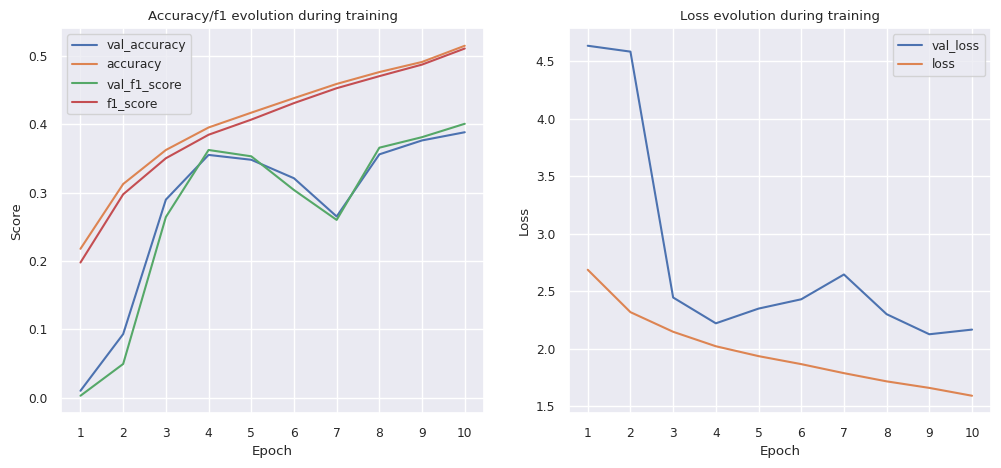

In [ ]:
history = get_full_training_history(model_id,training_history)
if history != None:
  save_training_history(model_id,history)
  #to avoid concat of same history when re-executing this cell
  training_history = None
  plot_training_history(history)

todo: comment

On va maintenant afficher le rapport de classification qui va nous donner une vision détaillée par classe des scores de prédiction.

In [ ]:

print(classification_report(y_test.astype("str"),test_pred_class))


              precision    recall  f1-score   support

          10       0.36      0.56      0.43       311
        1140       0.55      0.27      0.36       267
        1160       0.89      0.77      0.82       396
        1180       0.28      0.21      0.24        76
        1280       0.31      0.06      0.09       487
        1281       0.12      0.39      0.18       207
        1300       0.55      0.35      0.43       505
        1301       0.14      0.41      0.21        81
        1302       0.23      0.20      0.21       249
        1320       0.19      0.33      0.24       324
        1560       0.47      0.34      0.40       507
        1920       0.71      0.69      0.70       431
        1940       0.21      0.63      0.31        81
        2060       0.38      0.32      0.35       499
        2220       0.13      0.13      0.13        82
        2280       0.70      0.61      0.65       476
        2403       0.63      0.48      0.54       477
        2462       0.40    

todo: comment

Affichons la matrice de confusion sous forme de heatmap pour plus de lisibilité.

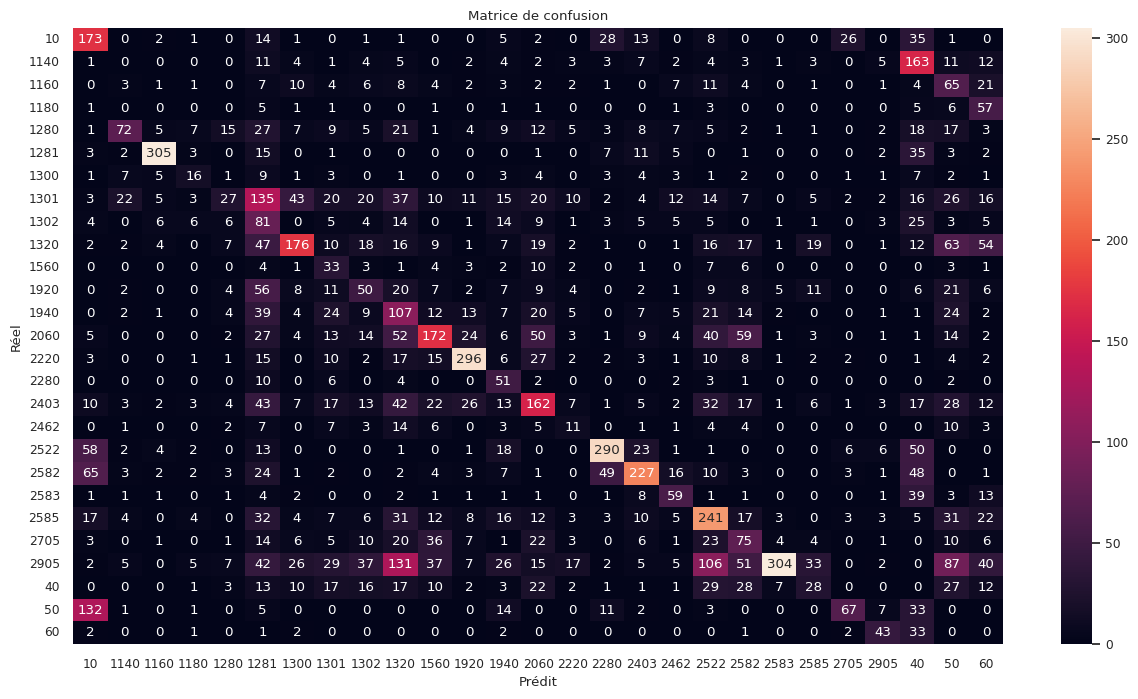

In [ ]:
cm = pd.crosstab(y_test,test_pred_class,rownames=["réel"],colnames=["prédit"])
plot_confusion_matrix(np.array(cm))



todo: comment

## Résumé

Nous avons atteint la fin de l'évaluation de cette modélisation. Affichons le rapport du modèle

In [ ]:
reporting_df.loc[model_id].T

model_name                                                        Modèle 1.1.1.1
dataset_source                 output/data-preprocessing-resampling/df_{train...
dataset_resampled                                                           True
image_dataset_source             output/data-preprocessing-images/images_pre.zip
image_dataset_zoomed                                                        True
train_size                                                               21913.0
image_size                                                                 224.0
image_color_rgb                                                             True
batch_size                                                                  64.0
image_data_generator_params    {'rescale': 0.00392156862745098, 'preprocessin...
start_lr                                                                   0.001
last_lr                                                                    0.001
optimizer                   

# Modélisation 1.2


On va maintenant tester les paramètres du même modèle mais en utilisant cette fois les images zoomées et un dataset avec des classes ré-équilibrées. Tous les autres paramètres restent identiques

Changeons la variables **model_id** pour qu'elle corresponde au modèle en cours

In [ ]:
model_id = 112

## Import des données

On importe donc les images zoomées qui ont été produites par le notebook **data_preprocessing_images**

In [ ]:
image_path = import_images("output/data-preprocessing-images/images_pre.zip","/tmp/rakuten-images-2")

extracting images from drive into colab's session storage... (about 1 min)


On charge maintenant le csv des données ré-équilibrées par le notebook **data_preprocessing_resampling**. Ce notebook étant executé à partir des données en sortie de **data_preprocessing_images**, il contient également la colonne **imagefile**.

Nous n'aurons pas besoin de refaire le split des données d'entrainement, **data_preprocessing_resampling** s'en étant déjà chargé. Nous avons juste à charger les trois fichiers qui constituent sa sortie:
* **df_train.csv**: L'ensemble d'entrainement
* **df_val.csv**: L'ensemble de validation
* **df_test.csv**: L'ensemble de test

In [ ]:
df_train = pd.read_csv("output/data-preprocessing-resampling/df_train.csv", index_col=0)
df_val = pd.read_csv("output/data-preprocessing-resampling/df_val.csv")
df_test = pd.read_csv("output/data-preprocessing-resampling/df_test.csv")
df_val.head()

,index,productid,imageid,text,lang,text_fr,imagefile,prdtypecode
0,64448,1951685748,1317996370,Linxor - Bâche à Bulles 300 microns Piscine 3m...,fr,Linxor - Bâche à Bulles 300 microns Piscine 3m...,2583/image_1317996370_product_1951685748.jpg,2583
1,37973,159494381,1029666610,Kit piscine autoportante Easy Set Ø 305 x 076m -,fr,Kit piscine autoportante Easy Set Ø 305 x 076m -,2583/image_1029666610_product_159494381.jpg,2583
2,73967,4011564183,1276163958,Kayak Gonflable Betta Hm K0 Biplace Et Ses Acc...,fr,Kayak Gonflable Betta Hm K0 Biplace Et Ses Acc...,1302/image_1276163958_product_4011564183.jpg,1302
3,33180,3797074222,1246071438,Mini Coloré En Plastique Pot De Fleurs Succule...,fr,Mini Coloré En Plastique Pot De Fleurs Succule...,2582/image_1246071438_product_3797074222.jpg,2582
4,26659,4157458648,1303079928,Modèle De Voiturerc Buggy Truck Chassis Body L...,fr,Modèle De Voiturerc Buggy Truck Chassis Body L...,1300/image_1303079928_product_4157458648.jpg,1300


## Preprocessing

Cette fois-ci, on va se contenter de créer les variables **X** et **y** correspondant aux différents ensembles, puis on va réduire leur nombre d'observations pour qu'il soit similaire à ce qu'on a utilisé pour les premières modélisations

In [ ]:
X_train = df_train.drop("prdtypecode",axis=1)
y_train = df_train["prdtypecode"]

X_validation = df_val.drop("prdtypecode",axis=1)
y_validation = df_val["prdtypecode"]

X_test = df_test.drop("prdtypecode",axis=1)
y_test = df_test["prdtypecode"]

On réduit l'ensemble d'entrainement pour qu'il contienne environ 50% des données de départ. le paramètre stratify étant égal à **y_train**, le nombre d'occurences de chaque classe en sortie devrait être équilibré

In [ ]:
target_train_size = int(len(X_train) * 0.30)
print("Target train size is", target_train_size)
train_split_rate = (len(X_train) - target_train_size) / len(X_train)
X_train, X_none, y_train, y_none = train_test_split(X_train,y_train,test_size=train_split_rate,random_state = random_state,
                                                    shuffle=True,stratify=y_train)
print("X_train length is now",len(X_train))

Target train size is 32869
X_train length is now 32869


Confirmons que les classes sont toujours équilibrées après la réduction.

In [ ]:
y_train.value_counts()

1320    1218
2522    1218
1302    1218
1300    1218
2220    1218
1560    1218
1281    1218
2060    1218
10      1218
2585    1218
2280    1217
40      1217
1180    1217
1301    1217
2705    1217
1140    1217
1920    1217
2462    1217
60      1217
1160    1217
1280    1217
2905    1217
50      1217
2583    1217
1940    1217
2582    1217
2403    1217
Name: prdtypecode, dtype: int64

C'est bien le cas

On va laisser les set de test et de validation inchangés car ils sont déjà calibré à 10% des données

## Initialisation du rapport de modéle

Si un fichier **model_reporting.csv** existe, on le charge. Autrement, on en crée un nouveau.

In [ ]:
Path(output_dir).mkdir(parents=True, exist_ok=True)
try:
  reporting_df = load_reporting_df()
  print("loaded ",output_dir+"/model_reporting.csv")
except FileNotFoundError:
  reporting_df = create_reporting_df()
  print(output_dir+"/model_reporting.csv","not found. creating one")


output/data-modeling-images-2/model_reporting.csv not found. creating one


In [ ]:
reporting_df.head()

,model_name,dataset_source,dataset_resampled,image_dataset_source,image_dataset_zoomed,train_size,image_size,image_color_rgb,batch_size,image_data_generator_params,...,fit_complete,f1_score,val_f1_score,test_f1_score,accuracy,val_accuracy,test_accuracy,loss,val_loss,remarks
model_id,,,,,,,,,,,,,,,,,,,,,
0,Example model,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,42458,300,True,32,"{'rescale': 0.00392156862745098, 'shear_range'...",...,True,0.42,0.37,0.35,0.57,0.39,0.41,1.567,2.657,Ceci n'est pas un vrai modèle. C'est juste un ...


Ajoutons une ligne correspondant à notre modèle et commençons à renseigner ses informations.

In [ ]:
add_reporting_line(model_id,"Modèle 1.1.2")

On peut déja renseigner les informations sur les données sources qu'on utilise

In [ ]:

update_reporting_line(model_id,{
    "dataset_source": "output/data-preprocessing-resampling/df_{train,val,test}.zip",
    "dataset_resampled": True,
    "image_dataset_source" : "output/data-preprocessing-images/images_pre.zip",
    "image_dataset_zoomed" : True,
    "train_size": len(X_train),
})

## Générateurs d'images

Commençons par créer une liste ordonnée des classes que l'on va fournir aux générateurs. Plus tard cette liste nous servira à retrouver les classes correspondant aux prédictions car la methode **predict** de keras retourne une matrice dont les colonnes correspondent aux classes dans l'ordre auquel on les a fourni.

In [ ]:
classes_keras = list(np.sort(np.array(df_train["prdtypecode"].unique(),dtype="str")))


On va reprendre ici les même générateurs d'image que pour la modélisation 1.1. On se contente de rappeler leur méthode **flow_from_dataframe** pour obtenir une instance adaptée au nouveau jeu de données.

On pense quand même à sauvegarder dans le rapport les paramètres de **ImageDataGenerator** pour le modèle en cours.

In [ ]:
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

update_reporting_line(model_id, {
    "image_data_generator_params" : {
      "rescale":1./255,
      "rotation_range":20,
      "width_shift_range":0.2,
      "height_shift_range":0.2,
      "shear_range":0.2,
      "zoom_range":0.2,
      "horizontal_flip":True,
      "vertical_flip":False,
      "fill_mode":'nearest'
      }
})

batch_size = 32
target_img_size = (224,224,3)
color_mode = "rgb"

update_reporting_line(model_id, {
    "batch_size":batch_size,
    "image_size": target_img_size[0],
    "image_color_rgb": True
})

train_generator = train_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_train['imagefile'],"prdtypecode": y_train.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 32869 validated image filenames belonging to 27 classes.


In [ ]:
validation_data_generator = ImageDataGenerator(
    rescale=1./255
)

validation_generator = validation_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_validation['imagefile'],"prdtypecode": y_validation.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 8492 validated image filenames belonging to 27 classes.


In [ ]:
test_data_generator = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_test['imagefile'],"prdtypecode": y_test.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras,
    shuffle=False
)

Found 8492 validated image filenames belonging to 27 classes.


## Création du model

S'il n'y a pas encore de modèle enregistré, on le construit puis on le compile en veillant à passer notre métrique **w_f1_score** personnalisée.
On conserve le même taux d'apprentissage de départ que dans la modélisation 1.1

In [ ]:
# model = load_saved_model(model_id)
start_lr = 0.001
print("build model")
model = build_model()
model.compile(
    optimizer=Adam(learning_rate=start_lr),
    loss='categorical_crossentropy',
    metrics=['accuracy', w_f1_score]
)
update_reporting_line(model_id,{
    "start_lr": start_lr,
    "optimizer": "adam",
})

model.summary()

build model
94765736/94765736 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)             

## Entrainement du model

On procéde à l'entrainement du modèle de la même façon que lors de la modélisation 1.1. Là encore, on réutilise les mêmes paramètres.

In [ ]:
target_epochs = 3
if not get_reporting_value(model_id,"fit_complete",False):
  update_reporting_line(model_id,{
      "target_epochs": target_epochs
  })
  training_history = model.fit(
      train_generator,
      validation_data=validation_generator,
      steps_per_epoch=train_generator.samples // batch_size,
      validation_steps = validation_generator.samples // batch_size,
      epochs=target_epochs - int(get_reporting_value(model_id,"last_epoch",0)),
      verbose=1,
      callbacks=[LogBest(model_id),early_stopping]
  )
  update_reporting_line(model_id,{"fit_complete":True})
else:
  print("No need to train model")
  training_history = None

Epoch 1/5
1027/1027 [==============================] - ETA: 0s - loss: 3.2156 - accuracy: 0.0767 - w_f1_score: 0.0617
Found better model with val_f1_score=0.05
save model  112 to  output/data-modeling-images-2/model-112.keras
1027/1027 [==============================] - 724s 662ms/step - loss: 3.2156 - accuracy: 0.0767 - w_f1_score: 0.0617 - val_loss: 3.1453 - val_accuracy: 0.0803 - val_w_f1_score: 0.0472
Epoch 2/5
1027/1027 [==============================] - ETA: 0s - loss: 2.9100 - accuracy: 0.1320 - w_f1_score: 0.1138
Found better model with val_f1_score=0.12
save model  112 to  output/data-modeling-images-2/model-112.keras
1027/1027 [==============================] - 614s 597ms/step - loss: 2.9100 - accuracy: 0.1320 - w_f1_score: 0.1138 - val_loss: 2.9564 - val_accuracy: 0.1467 - val_w_f1_score: 0.1223
Epoch 3/5
1027/1027 [==============================] - 591s 575ms/step - loss: 2.7257 - accuracy: 0.1835 - w_f1_score: 0.1658 - val_loss: 4.3107 - val_accuracy: 0.1053 - val_w_f1_sco

## Evaluation du modèle

Si un entrainement a eu lieu au cours de cette execution du notebook, on recharge le meilleur modèle qu'on a trouvé

In [ ]:
if training_history != None:
  #if fit wad called, make sure to load best saved model, otherwise it's already loaded
  model = load_saved_model(model_id)


Load previous model from output/data-modeling-images-2/model-112.keras


On teste le modèle sur l'ensemble de test

In [ ]:
test_pred = model.predict(test_generator,verbose=1)

266/266 [==============================] - 49s 180ms/step


On doit convertir le resulat de **predict** depuis le format renvoyés par keras qui est une matrice de probabilités avec les classes en colonnes et les observations du jeu de test en lignes en un tableau à 1 dimension contenant les classes prédites pour chaque observation.

Pour cela, on extrait pour chaque observation l'index de la probabilité max de prédiction. On utilise ensuite cet index pour retrouver la classe correspondante dans **classes_keras**, la liste des classes telle qu'on la fourni à keras.

In [ ]:
test_pred_class = np.argmax(test_pred,axis=1)
test_pred_class = [classes_keras[c] for c in test_pred_class]

A partir des classes prédites et des observations réelles, on calcul, le score f1 ainsi que l'accuracy de notre modèle, toujours sur le jeu de test.

On enregistre ces infos dans le rapport.

In [ ]:
f1_weighted = f1_score(y_test.astype("str"),test_pred_class,average="weighted")
accuracy = accuracy_score(y_test.astype("str"),test_pred_class)
update_reporting_line(model_id,{
    "test_f1_score":f1_weighted,
    "test_accuracy":f1_weighted
})

print("f1_score on test dataset=%.2f" % f1_weighted)
print("accuracy on test dataset=%.2f" % accuracy)

f1_score on test dataset=0.15
accuracy on test dataset=0.17


On récupère l'historique d'entrainement complet gràce à **get_full_training_history** qu'on va enregistrer puis on affiche deux graphiques:

* L'évolution de l'accuracy et du score f1 pendant en fonction des époques
* L'évolution des indicateurs de perte **loss** et **val_loss**

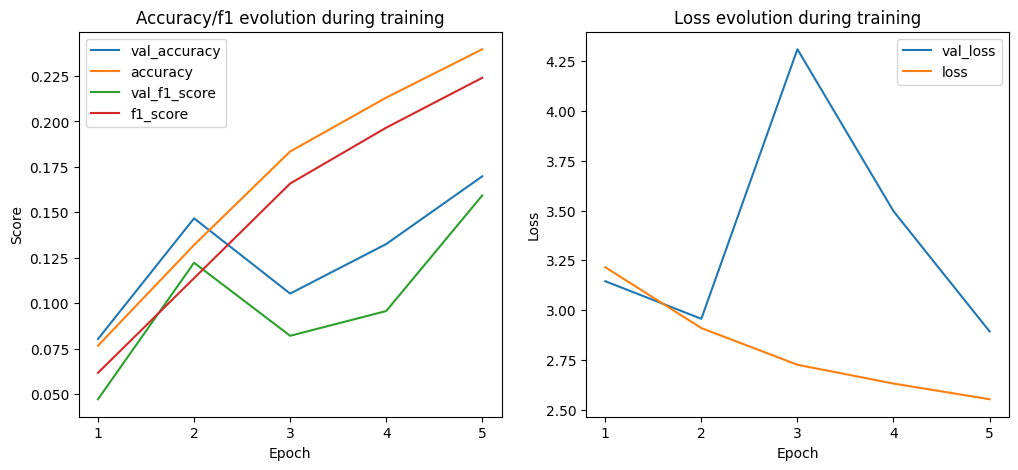

In [ ]:
history = get_full_training_history(model_id,training_history)
if history != None:
  save_training_history(model_id,history)
  #to avoid concat of same history when re-executing this cell
  training_history = None
  plot_training_history(history)

todo: comment

On va maintenant afficher le rapport de classification qui va nous donner une vision détaillée par classe des scores de prédiction.

In [ ]:

print(classification_report(y_test.astype("str"),test_pred_class))


              precision    recall  f1-score   support

          10       0.20      0.21      0.20       311
        1140       0.42      0.10      0.16       267
        1160       0.44      0.07      0.12       396
        1180       0.04      0.11      0.06        76
        1280       0.00      0.00      0.00       487
        1281       0.00      0.00      0.00       207
        1300       0.21      0.17      0.19       505
        1301       0.02      0.02      0.02        81
        1302       0.12      0.02      0.03       249
        1320       0.26      0.03      0.06       324
        1560       0.13      0.27      0.17       507
        1920       0.13      0.31      0.18       431
        1940       0.08      0.25      0.12        81
        2060       0.25      0.17      0.20       499
        2220       0.00      0.00      0.00        82
        2280       0.20      0.38      0.26       476
        2403       0.21      0.19      0.20       477
        2462       0.12    

todo: comment

Affichons la matrice de confusion sous forme de heatmap pour plus de lisibilité.

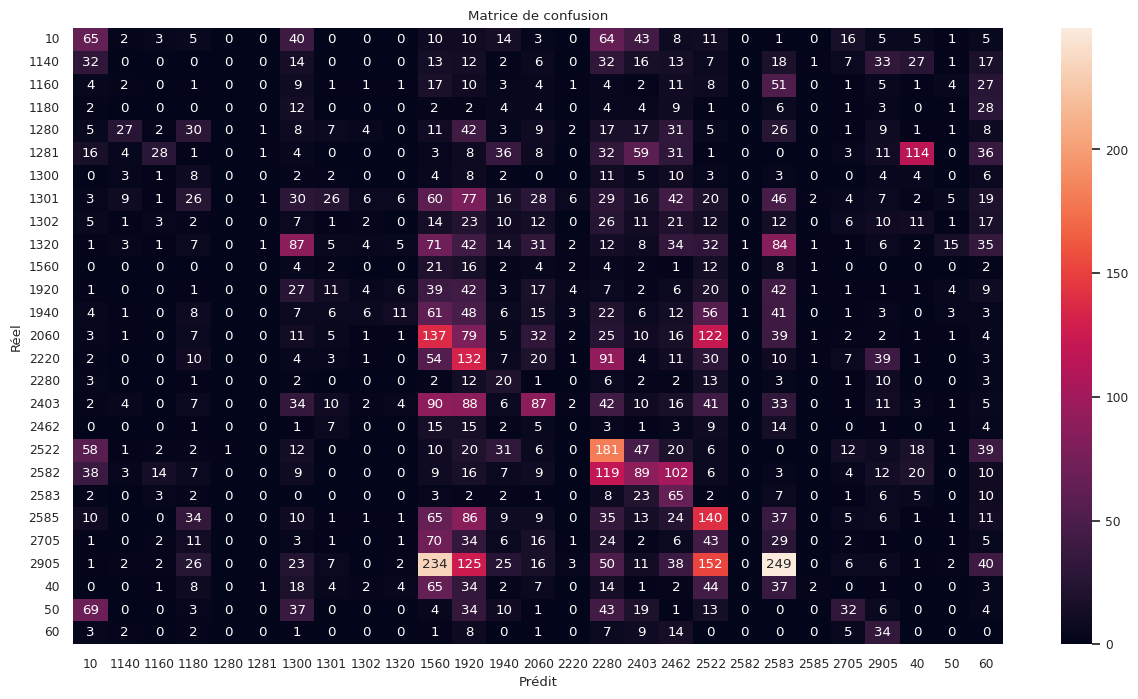

In [ ]:
cm = pd.crosstab(y_test,test_pred_class,rownames=["réel"],colnames=["prédit"])
plot_confusion_matrix(np.array(cm))



todo: comment

## Résumé

Nous avons atteint la fin de l'évaluation de cette modélisation. Affichons le rapport du modèle

In [ ]:
reporting_df.loc[model_id].T

model_name                                                          Modèle 1.1.2
dataset_source                 output/data-preprocessing-resampling/df_{train...
dataset_resampled                                                           True
image_dataset_source             output/data-preprocessing-images/images_pre.zip
image_dataset_zoomed                                                        True
train_size                                                               32869.0
image_size                                                                 224.0
image_color_rgb                                                             True
batch_size                                                                  32.0
image_data_generator_params    {'rescale': 0.00392156862745098, 'rotation_ran...
start_lr                                                                   0.001
last_lr                                                                    0.001
optimizer                   

# Modélisation 1.3

On va maintenant tester les paramètres du même modèle mais en utilisant cette fois les images zoomées et un dataset avec des classes ré-équilibrées. Tous les autres paramètres restent identiques

Changeons la variables **model_id** pour qu'elle corresponde au modèle en cours

In [ ]:
model_id = 113

## Import des données

On importe donc les images zoomées qui ont été produites par le notebook **data_preprocessing_images**

In [ ]:
image_path = import_images("output/data-preprocessing-images/images_pre.zip","/tmp/rakuten-images-2")

images already imported from drive


On charge maintenant le csv des données ré-équilibrées par le notebook **data_preprocessing_resampling**. Ce notebook étant executé à partir des données en sortie de **data_preprocessing_images**, il contient également la colonne **imagefile**.

Nous n'aurons pas besoin de refaire le split des données d'entrainement, **data_preprocessing_resampling** s'en étant déjà chargé. Nous avons juste à charger les trois fichiers qui constituent sa sortie:
* **df_train.csv**: L'ensemble d'entrainement
* **df_val.csv**: L'ensemble de validation
* **df_test.csv**: L'ensemble de test

In [ ]:
df_train = pd.read_csv("output/data-preprocessing-resampling/df_train.csv", index_col=0)
df_val = pd.read_csv("output/data-preprocessing-resampling/df_val.csv")
df_test = pd.read_csv("output/data-preprocessing-resampling/df_test.csv")
df_val.head()

,index,productid,imageid,text,lang,text_fr,imagefile,prdtypecode
0,64448,1951685748,1317996370,Linxor - Bâche à Bulles 300 microns Piscine 3m...,fr,Linxor - Bâche à Bulles 300 microns Piscine 3m...,2583/image_1317996370_product_1951685748.jpg,2583
1,37973,159494381,1029666610,Kit piscine autoportante Easy Set Ø 305 x 076m -,fr,Kit piscine autoportante Easy Set Ø 305 x 076m -,2583/image_1029666610_product_159494381.jpg,2583
2,73967,4011564183,1276163958,Kayak Gonflable Betta Hm K0 Biplace Et Ses Acc...,fr,Kayak Gonflable Betta Hm K0 Biplace Et Ses Acc...,1302/image_1276163958_product_4011564183.jpg,1302
3,33180,3797074222,1246071438,Mini Coloré En Plastique Pot De Fleurs Succule...,fr,Mini Coloré En Plastique Pot De Fleurs Succule...,2582/image_1246071438_product_3797074222.jpg,2582
4,26659,4157458648,1303079928,Modèle De Voiturerc Buggy Truck Chassis Body L...,fr,Modèle De Voiturerc Buggy Truck Chassis Body L...,1300/image_1303079928_product_4157458648.jpg,1300


## Preprocessing

Cette fois-ci, on va se contenter de créer les variables **X** et **y** correspondant aux différents ensembles, puis on va réduire leur nombre d'observations pour qu'il soit similaire à ce qu'on a utilisé pour les premières modélisations

In [ ]:
X_train = df_train.drop("prdtypecode",axis=1)
y_train = df_train["prdtypecode"]

X_validation = df_val.drop("prdtypecode",axis=1)
y_validation = df_val["prdtypecode"]

X_test = df_test.drop("prdtypecode",axis=1)
y_test = df_test["prdtypecode"]

On réduit l'ensemble d'entrainement pour qu'il contienne environ 50% des données de départ. le paramètre stratify étant égal à **y_train**, le nombre d'occurences de chaque classe en sortie devrait être équilibré

In [ ]:
target_train_size = int(len(X_train) * 0.25)
print("Target train size is", target_train_size)
train_split_rate = (len(X_train) - target_train_size) / len(X_train)
X_train, X_none, y_train, y_none = train_test_split(X_train,y_train,test_size=train_split_rate,random_state = random_state,
                                                    shuffle=True,stratify=y_train)
print("X_train length is now",len(X_train))

Target train size is 27391
X_train length is now 27391


Confirmons que les classes sont toujours équilibrées après la réduction.

In [ ]:
y_train.value_counts()

1320    1015
1560    1015
2220    1015
1281    1015
2585    1015
40      1015
10      1015
2522    1015
1140    1015
1160    1015
1300    1015
1302    1015
2060    1015
2705    1014
60      1014
2583    1014
2582    1014
1301    1014
50      1014
2280    1014
1180    1014
2905    1014
1920    1014
1280    1014
1940    1014
2462    1014
2403    1014
Name: prdtypecode, dtype: int64

C'est bien le cas

On va laisser les set de test et de validation inchangés car ils sont déjà calibré à 10% des données

## Initialisation du rapport de modéle

Si un fichier **model_reporting.csv** existe, on le charge. Autrement, on en crée un nouveau.

In [ ]:
Path(output_dir).mkdir(parents=True, exist_ok=True)
try:
  reporting_df = load_reporting_df()
  print("loaded ",output_dir+"/model_reporting.csv")
except FileNotFoundError:
  reporting_df = create_reporting_df()
  print(output_dir+"/model_reporting.csv","not found. creating one")


loaded  output/data-modeling-images-2/model_reporting.csv


In [ ]:
reporting_df.head()

,model_name,dataset_source,dataset_resampled,image_dataset_source,image_dataset_zoomed,train_size,image_size,image_color_rgb,batch_size,image_data_generator_params,...,fit_complete,f1_score,val_f1_score,test_f1_score,accuracy,val_accuracy,test_accuracy,loss,val_loss,remarks
model_id,,,,,,,,,,,,,,,,,,,,,
0,Example model,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,42458.0,300.0,True,32.0,"{'rescale': 0.00392156862745098, 'shear_range'...",...,True,0.420000,0.370000,0.350000,0.570000,0.390000,0.410000,1.567000,2.657000,Ceci n'est pas un vrai modèle. C'est juste un ...
112,Modèle 1.1.2,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,32869.0,224.0,True,32.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.223995,0.159299,0.153432,0.239699,0.169811,0.153432,2.552496,2.893241,NaN
111,Modèle 1.1.1,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,21913.0,224.0,True,64.0,"{'rescale': 0.00392156862745098, 'preprocessin...",...,True,0.491908,0.411804,0.416277,0.495126,0.402107,0.416277,1.654593,2.027163,NaN


Ajoutons une ligne correspondant à notre modèle et commençons à renseigner ses informations.

In [ ]:
add_reporting_line(model_id,"Modèle 1.1.3")

On peut déja renseigner les informations sur les données sources qu'on utilise

In [ ]:

update_reporting_line(model_id,{
    "dataset_source": "output/data-preprocessing-resampling/df_{train,val,test}.zip",
    "dataset_resampled": True,
    "image_dataset_source" : "output/data-preprocessing-images/images_pre.zip",
    "image_dataset_zoomed" : True,
    "train_size": len(X_train),
})

## Générateurs d'images

Commençons par créer une liste ordonnée des classes que l'on va fournir aux générateurs. Plus tard cette liste nous servira à retrouver les classes correspondant aux prédictions car la methode **predict** de keras retourne une matrice dont les colonnes correspondent aux classes dans l'ordre auquel on les a fourni.

In [ ]:
classes_keras = list(np.sort(np.array(df_train["prdtypecode"].unique(),dtype="str")))


On va reprendre ici les même générateurs d'image que pour la modélisation 1.1. On se contente de rappeler leur méthode **flow_from_dataframe** pour obtenir une instance adaptée au nouveau jeu de données.

On pense quand même à sauvegarder dans le rapport les paramètres de **ImageDataGenerator** pour le modèle en cours.

In [ ]:
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=5,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

update_reporting_line(model_id, {
    "image_data_generator_params" : {
      "rescale":1./255,
      'preprocessing_function':'preprocess_input',
      "rotation_range":20,
      "width_shift_range":0.1,
      "height_shift_range":0.1,
      "shear_range":5,
      "zoom_range":0.1,
      "horizontal_flip":True,
      "vertical_flip":True,
      "fill_mode":'nearest'
      }
})

batch_size = 64
target_img_size = (224,224,3)
color_mode = "rgb"

update_reporting_line(model_id, {
    "batch_size":batch_size,
    "image_size": target_img_size[0],
    "image_color_rgb": True
})

train_generator = train_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_train['imagefile'],"prdtypecode": y_train.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 27391 validated image filenames belonging to 27 classes.


In [ ]:
validation_data_generator = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input
)

validation_generator = validation_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_validation['imagefile'],"prdtypecode": y_validation.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 8492 validated image filenames belonging to 27 classes.


In [ ]:
test_data_generator = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input
)

test_generator = test_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_test['imagefile'],"prdtypecode": y_test.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras,
    shuffle=False
)

Found 8492 validated image filenames belonging to 27 classes.


## Création du model

S'il n'y a pas encore de modèle enregistré, on le construit puis on le compile en veillant à passer notre métrique **w_f1_score** personnalisée.
On conserve le même taux d'apprentissage de départ que dans la modélisation 1.1

In [ ]:
# model = load_saved_model(model_id)
start_lr = 0.001
print("build model")
model = build_model()
model.compile(
    optimizer=Adam(learning_rate=start_lr),
    loss='categorical_crossentropy',
    metrics=['accuracy', w_f1_score]
)
update_reporting_line(model_id,{
    "start_lr": start_lr,
    "optimizer": "adam",
})

model.summary()

build model
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                            

## Entrainement du model

On procéde à l'entrainement du modèle de la même façon que lors de la modélisation 1.1. Là encore, on réutilise les mêmes paramètres.

In [ ]:
target_epochs = 10
if not get_reporting_value(model_id,"fit_complete",False):
  update_reporting_line(model_id,{
      "target_epochs": target_epochs
  })
  training_history = model.fit(
      train_generator,
      validation_data=validation_generator,
      steps_per_epoch=train_generator.samples // batch_size,
      validation_steps = validation_generator.samples // batch_size,
      epochs=target_epochs - int(get_reporting_value(model_id,"last_epoch",0)),
      verbose=1,
      callbacks=[LogBest(model_id),early_stopping]
  )
  update_reporting_line(model_id,{"fit_complete":True})
else:
  print("No need to train model")
  training_history = None

Epoch 1/10
427/427 [==============================] - ETA: 0s - loss: 2.9633 - accuracy: 0.1329 - w_f1_score: 0.1122
Found better model with val_f1_score=0.01
save model  113 to  output/data-modeling-images-2/model-113.keras
427/427 [==============================] - 610s 1s/step - loss: 2.9633 - accuracy: 0.1329 - w_f1_score: 0.1122 - val_loss: 3.8684 - val_accuracy: 0.0430 - val_w_f1_score: 0.0130
Epoch 2/10
427/427 [==============================] - ETA: 0s - loss: 2.6360 - accuracy: 0.2143 - w_f1_score: 0.1961
Found better model with val_f1_score=0.18
save model  113 to  output/data-modeling-images-2/model-113.keras
427/427 [==============================] - 580s 1s/step - loss: 2.6360 - accuracy: 0.2143 - w_f1_score: 0.1961 - val_loss: 2.7827 - val_accuracy: 0.1950 - val_w_f1_score: 0.1822
Epoch 3/10
427/427 [==============================] - 537s 1s/step - loss: 2.4927 - accuracy: 0.2565 - w_f1_score: 0.2397 - val_loss: 3.2509 - val_accuracy: 0.1407 - val_w_f1_score: 0.1109
Epoch

## Evaluation du modèle

Si un entrainement a eu lieu au cours de cette execution du notebook, on recharge le meilleur modèle qu'on a trouvé

In [ ]:
if training_history != None:
  #if fit wad called, make sure to load best saved model, otherwise it's already loaded
  model = load_saved_model(model_id)


Load previous model from output/data-modeling-images-2/model-113.keras


On teste le modèle sur l'ensemble de test

In [ ]:
test_pred = model.predict(test_generator,verbose=1)

133/133 [==============================] - 65s 479ms/step


On doit convertir le resulat de **predict** depuis le format renvoyés par keras qui est une matrice de probabilités avec les classes en colonnes et les observations du jeu de test en lignes en un tableau à 1 dimension contenant les classes prédites pour chaque observation.

Pour cela, on extrait pour chaque observation l'index de la probabilité max de prédiction. On utilise ensuite cet index pour retrouver la classe correspondante dans **classes_keras**, la liste des classes telle qu'on la fourni à keras.

In [ ]:
test_pred_class = np.argmax(test_pred,axis=1)
test_pred_class = [classes_keras[c] for c in test_pred_class]

A partir des classes prédites et des observations réelles, on calcul, le score f1 ainsi que l'accuracy de notre modèle, toujours sur le jeu de test.

On enregistre ces infos dans le rapport.

In [ ]:
f1_weighted = f1_score(y_test.astype("str"),test_pred_class,average="weighted")
accuracy = accuracy_score(y_test.astype("str"),test_pred_class)
update_reporting_line(model_id,{
    "test_f1_score":f1_weighted,
    "test_accuracy":f1_weighted
})

print("f1_score on test dataset=%.2f" % f1_weighted)
print("accuracy on test dataset=%.2f" % accuracy)

f1_score on test dataset=0.29
accuracy on test dataset=0.31


On récupère l'historique d'entrainement complet gràce à **get_full_training_history** qu'on va enregistrer puis on affiche deux graphiques:

* L'évolution de l'accuracy et du score f1 pendant en fonction des époques
* L'évolution des indicateurs de perte **loss** et **val_loss**

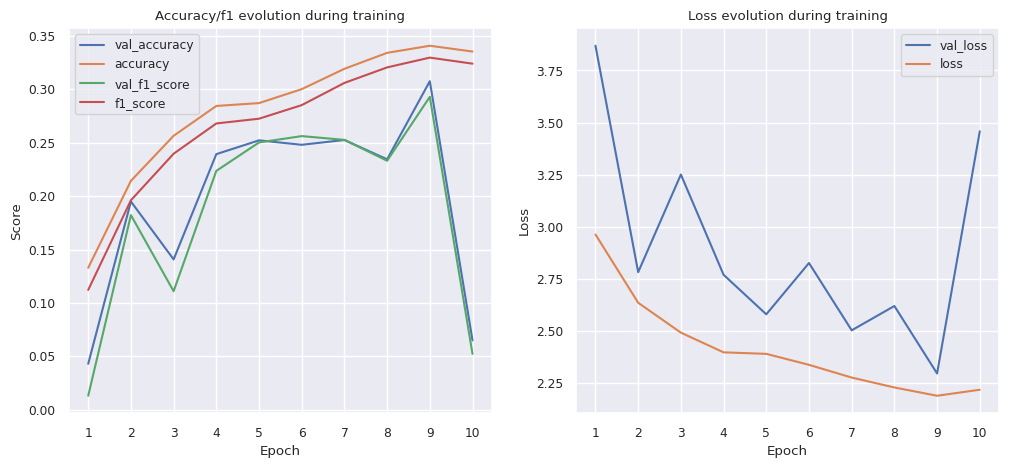

In [ ]:
history = get_full_training_history(model_id,training_history)
if history != None:
  save_training_history(model_id,history)
  #to avoid concat of same history when re-executing this cell
  training_history = None
  plot_training_history(history)

todo: comment

On va maintenant afficher le rapport de classification qui va nous donner une vision détaillée par classe des scores de prédiction.

In [ ]:

print(classification_report(y_test.astype("str"),test_pred_class))


              precision    recall  f1-score   support

          10       0.29      0.40      0.34       311
        1140       0.37      0.21      0.27       267
        1160       0.66      0.77      0.71       396
        1180       0.12      0.17      0.14        76
        1280       0.22      0.05      0.07       487
        1281       0.17      0.05      0.07       207
        1300       0.25      0.29      0.27       505
        1301       0.11      0.16      0.13        81
        1302       0.16      0.10      0.12       249
        1320       0.28      0.12      0.17       324
        1560       0.45      0.08      0.14       507
        1920       0.37      0.77      0.50       431
        1940       0.16      0.41      0.23        81
        2060       0.28      0.13      0.18       499
        2220       0.06      0.13      0.08        82
        2280       0.40      0.72      0.52       476
        2403       0.41      0.47      0.44       477
        2462       0.26    

todo: comment

Affichons la matrice de confusion sous forme de heatmap pour plus de lisibilité.

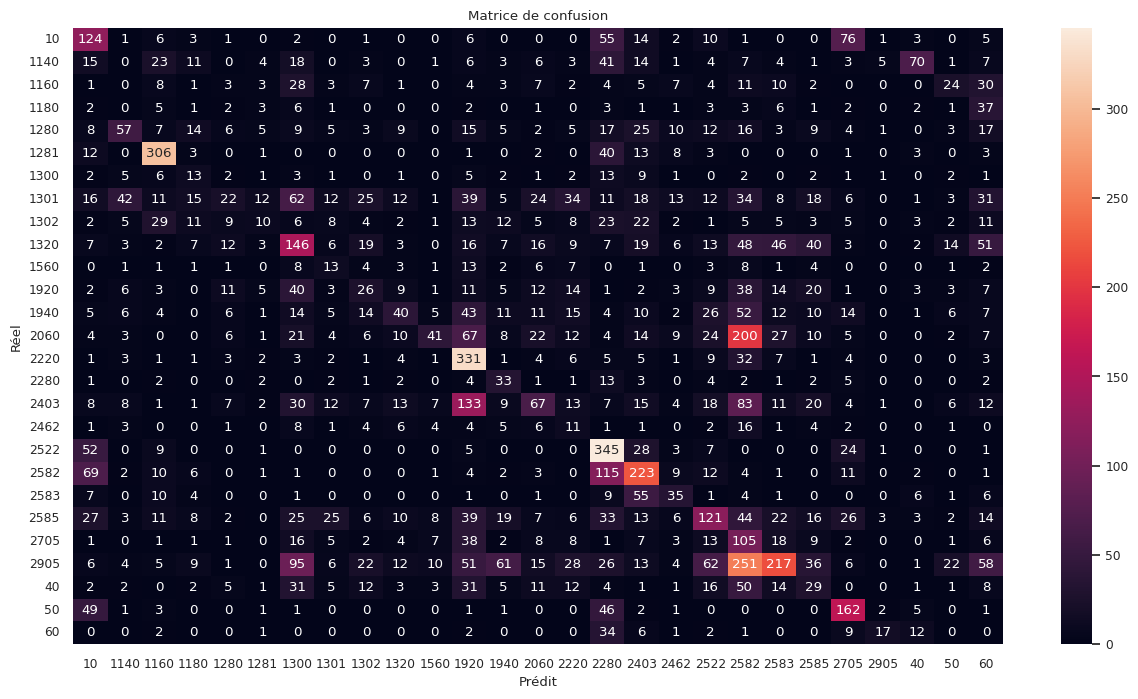

In [ ]:
cm = pd.crosstab(y_test,test_pred_class,rownames=["réel"],colnames=["prédit"])
plot_confusion_matrix(np.array(cm))



todo: comment

## Résumé

Nous avons atteint la fin de l'évaluation de cette modélisation. Affichons le rapport du modèle

In [ ]:
reporting_df.loc[model_id].T

model_name                                                          Modèle 1.1.3
dataset_source                 output/data-preprocessing-resampling/df_{train...
dataset_resampled                                                           True
image_dataset_source             output/data-preprocessing-images/images_pre.zip
image_dataset_zoomed                                                        True
train_size                                                               27391.0
image_size                                                                 224.0
image_color_rgb                                                             True
batch_size                                                                  64.0
image_data_generator_params    {'rescale': 0.00392156862745098, 'preprocessin...
start_lr                                                                   0.001
last_lr                                                                    0.001
optimizer                   

# Modélisation 1.4

On va maintenant tester les paramètres du même modèle mais en utilisant cette fois les images zoomées et un dataset avec des classes ré-équilibrées. Tous les autres paramètres restent identiques

Changeons la variables **model_id** pour qu'elle corresponde au modèle en cours

In [ ]:
model_id = 114

## Import des données

On importe donc les images zoomées qui ont été produites par le notebook **data_preprocessing_images**

In [ ]:
image_path = import_images("output/data-preprocessing-images/images_pre.zip","/tmp/rakuten-images-2")

images already imported from drive


On charge maintenant le csv des données ré-équilibrées par le notebook **data_preprocessing_resampling**. Ce notebook étant executé à partir des données en sortie de **data_preprocessing_images**, il contient également la colonne **imagefile**.

Nous n'aurons pas besoin de refaire le split des données d'entrainement, **data_preprocessing_resampling** s'en étant déjà chargé. Nous avons juste à charger les trois fichiers qui constituent sa sortie:
* **df_train.csv**: L'ensemble d'entrainement
* **df_val.csv**: L'ensemble de validation
* **df_test.csv**: L'ensemble de test

In [ ]:
df_train = pd.read_csv("output/data-preprocessing-resampling/df_train.csv", index_col=0)
df_val = pd.read_csv("output/data-preprocessing-resampling/df_val.csv")
df_test = pd.read_csv("output/data-preprocessing-resampling/df_test.csv")
df_val.head()

,index,productid,imageid,text,lang,text_fr,imagefile,prdtypecode
0,64448,1951685748,1317996370,Linxor - Bâche à Bulles 300 microns Piscine 3m...,fr,Linxor - Bâche à Bulles 300 microns Piscine 3m...,2583/image_1317996370_product_1951685748.jpg,2583
1,37973,159494381,1029666610,Kit piscine autoportante Easy Set Ø 305 x 076m -,fr,Kit piscine autoportante Easy Set Ø 305 x 076m -,2583/image_1029666610_product_159494381.jpg,2583
2,73967,4011564183,1276163958,Kayak Gonflable Betta Hm K0 Biplace Et Ses Acc...,fr,Kayak Gonflable Betta Hm K0 Biplace Et Ses Acc...,1302/image_1276163958_product_4011564183.jpg,1302
3,33180,3797074222,1246071438,Mini Coloré En Plastique Pot De Fleurs Succule...,fr,Mini Coloré En Plastique Pot De Fleurs Succule...,2582/image_1246071438_product_3797074222.jpg,2582
4,26659,4157458648,1303079928,Modèle De Voiturerc Buggy Truck Chassis Body L...,fr,Modèle De Voiturerc Buggy Truck Chassis Body L...,1300/image_1303079928_product_4157458648.jpg,1300


## Preprocessing

Cette fois-ci, on va se contenter de créer les variables **X** et **y** correspondant aux différents ensembles, puis on va réduire leur nombre d'observations pour qu'il soit similaire à ce qu'on a utilisé pour les premières modélisations

In [ ]:
X_train = df_train.drop("prdtypecode",axis=1)
y_train = df_train["prdtypecode"]

X_validation = df_val.drop("prdtypecode",axis=1)
y_validation = df_val["prdtypecode"]

X_test = df_test.drop("prdtypecode",axis=1)
y_test = df_test["prdtypecode"]

On réduit l'ensemble d'entrainement pour qu'il contienne environ 50% des données de départ. le paramètre stratify étant égal à **y_train**, le nombre d'occurences de chaque classe en sortie devrait être équilibré

In [ ]:
target_train_size = int(len(X_train))
print("Target train size is", target_train_size)
train_split_rate = 0.2
X_train, X_none, y_train, y_none = train_test_split(X_train,y_train,test_size=train_split_rate,random_state = random_state,
                                                    shuffle=True,stratify=y_train)
print("X_train length is now",len(X_train))

Target train size is 109566
X_train length is now 87652


Confirmons que les classes sont toujours équilibrées après la réduction.

In [ ]:
y_train.value_counts()

2220    3247
2522    3247
1302    3247
10      3247
2060    3247
1560    3247
1320    3247
2585    3247
1300    3247
1281    3247
2582    3246
1301    3246
1940    3246
50      3246
40      3246
2403    3246
2905    3246
1280    3246
2462    3246
1920    3246
60      3246
2583    3246
1140    3246
1180    3246
2280    3246
2705    3246
1160    3246
Name: prdtypecode, dtype: int64

C'est bien le cas

On va laisser les set de test et de validation inchangés car ils sont déjà calibré à 10% des données

## Initialisation du rapport de modéle

Si un fichier **model_reporting.csv** existe, on le charge. Autrement, on en crée un nouveau.

In [ ]:
Path(output_dir).mkdir(parents=True, exist_ok=True)
try:
  reporting_df = load_reporting_df()
  print("loaded ",output_dir+"/model_reporting.csv")
except FileNotFoundError:
  reporting_df = create_reporting_df()
  print(output_dir+"/model_reporting.csv","not found. creating one")


loaded  output/data-modeling-images-2/model_reporting.csv


In [ ]:
reporting_df.head()

,model_name,dataset_source,dataset_resampled,image_dataset_source,image_dataset_zoomed,train_size,image_size,image_color_rgb,batch_size,image_data_generator_params,...,fit_complete,f1_score,val_f1_score,test_f1_score,accuracy,val_accuracy,test_accuracy,loss,val_loss,remarks
model_id,,,,,,,,,,,,,,,,,,,,,
0,Example model,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,42458.0,300.0,True,32.0,"{'rescale': 0.00392156862745098, 'shear_range'...",...,True,0.420000,0.370000,0.350000,0.570000,0.390000,0.410000,1.567000,2.657000,Ceci n'est pas un vrai modèle. C'est juste un ...
112,Modèle 1.1.2,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,32869.0,224.0,True,32.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.223995,0.159299,0.153432,0.239699,0.169811,0.153432,2.552496,2.893241,NaN
111,Modèle 1.1.1,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,21913.0,224.0,True,64.0,"{'rescale': 0.00392156862745098, 'preprocessin...",...,True,0.491908,0.411804,0.416277,0.495126,0.402107,0.416277,1.654593,2.027163,NaN
113,Modèle 1.1.3,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,27391.0,224.0,True,64.0,"{'rescale': 0.00392156862745098, 'preprocessin...",...,True,0.329768,0.293019,0.290177,0.340872,0.307647,0.290177,2.190135,2.296956,NaN
1111,Modèle 1.1.1.1,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,21913.0,224.0,True,64.0,"{'rescale': 0.00392156862745098, 'preprocessin...",...,True,0.510486,0.400509,0.405420,0.514532,0.388139,0.405420,1.590917,2.166416,NaN


Ajoutons une ligne correspondant à notre modèle et commençons à renseigner ses informations.

In [ ]:
add_reporting_line(model_id,"Modèle 1.1.4")

On peut déja renseigner les informations sur les données sources qu'on utilise

In [ ]:

update_reporting_line(model_id,{
    "dataset_source": "output/data-preprocessing-resampling/df_{train,val,test}.zip",
    "dataset_resampled": True,
    "image_dataset_source" : "output/data-preprocessing-images/images_pre.zip",
    "image_dataset_zoomed" : True,
    "train_size": len(X_train),
})

## Générateurs d'images

Commençons par créer une liste ordonnée des classes que l'on va fournir aux générateurs. Plus tard cette liste nous servira à retrouver les classes correspondant aux prédictions car la methode **predict** de keras retourne une matrice dont les colonnes correspondent aux classes dans l'ordre auquel on les a fourni.

In [ ]:
classes_keras = list(np.sort(np.array(df_train["prdtypecode"].unique(),dtype="str")))


On va reprendre ici les même générateurs d'image que pour la modélisation 1.1. On se contente de rappeler leur méthode **flow_from_dataframe** pour obtenir une instance adaptée au nouveau jeu de données.

On pense quand même à sauvegarder dans le rapport les paramètres de **ImageDataGenerator** pour le modèle en cours.

In [ ]:
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=5,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

update_reporting_line(model_id, {
    "image_data_generator_params" : {
      "rescale":1./255,
      'preprocessing_function':'preprocess_input',
      "rotation_range":20,
      "width_shift_range":0.2,
      "height_shift_range":0.2,
      "shear_range":5,
      "zoom_range":0.1,
      "horizontal_flip":True,
      "vertical_flip":True,
      "fill_mode":'nearest'
      }
})

batch_size = 64
target_img_size = (224,224,3)
color_mode = "rgb"

update_reporting_line(model_id, {
    "batch_size":batch_size,
    "image_size": target_img_size[0],
    "image_color_rgb": True
})

train_generator = train_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_train['imagefile'],"prdtypecode": y_train.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 87652 validated image filenames belonging to 27 classes.


In [ ]:
validation_data_generator = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input
)

validation_generator = validation_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_validation['imagefile'],"prdtypecode": y_validation.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 8492 validated image filenames belonging to 27 classes.


In [ ]:
test_data_generator = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input,
)

test_generator = test_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_test['imagefile'],"prdtypecode": y_test.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras,
    shuffle=False
)

Found 8492 validated image filenames belonging to 27 classes.


## Création du model

S'il n'y a pas encore de modèle enregistré, on le construit puis on le compile en veillant à passer notre métrique **w_f1_score** personnalisée.
On conserve le même taux d'apprentissage de départ que dans la modélisation 1.1

In [ ]:
# model = load_saved_model(model_id)
start_lr = 0.001
print("build model")
model = build_model()
model.compile(
    optimizer=Adam(learning_rate=start_lr),
    loss='categorical_crossentropy',
    metrics=['accuracy', w_f1_score]
)
update_reporting_line(model_id,{
    "start_lr": start_lr,
    "optimizer": "adam",
})

build model
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_8[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                            

## Entrainement du model

On procéde à l'entrainement du modèle de la même façon que lors de la modélisation 1.1. Là encore, on réutilise les mêmes paramètres.

In [ ]:
target_epochs = 10
if not get_reporting_value(model_id,"fit_complete",False):
  update_reporting_line(model_id,{
      "target_epochs": target_epochs
  })
  training_history = model.fit(
      train_generator,
      validation_data=validation_generator,
      steps_per_epoch=train_generator.samples // batch_size,
      validation_steps = validation_generator.samples // batch_size,
      epochs=target_epochs - int(get_reporting_value(model_id,"last_epoch",0)),
      verbose=1,
      callbacks=[LogBest(model_id),early_stopping]
  )
  update_reporting_line(model_id,{"fit_complete":True})
else:
  print("No need to train model")
  training_history = None

No need to train model


## Evaluation du modèle

Si un entrainement a eu lieu au cours de cette execution du notebook, on recharge le meilleur modèle qu'on a trouvé

In [ ]:
if training_history != None:
  #if fit wad called, make sure to load best saved model, otherwise it's already loaded
  model = load_saved_model(model_id)


On teste le modèle sur l'ensemble de test

In [ ]:
test_pred = model.predict(test_generator,verbose=1)

133/133 [==============================] - 65s 480ms/step


On doit convertir le resulat de **predict** depuis le format renvoyés par keras qui est une matrice de probabilités avec les classes en colonnes et les observations du jeu de test en lignes en un tableau à 1 dimension contenant les classes prédites pour chaque observation.

Pour cela, on extrait pour chaque observation l'index de la probabilité max de prédiction. On utilise ensuite cet index pour retrouver la classe correspondante dans **classes_keras**, la liste des classes telle qu'on la fourni à keras.

In [ ]:
test_pred_class = np.argmax(test_pred,axis=1)
test_pred_class = [classes_keras[c] for c in test_pred_class]

A partir des classes prédites et des observations réelles, on calcul, le score f1 ainsi que l'accuracy de notre modèle, toujours sur le jeu de test.

On enregistre ces infos dans le rapport.

In [ ]:
f1_weighted = f1_score(y_test.astype("str"),test_pred_class,average="weighted")
accuracy = accuracy_score(y_test.astype("str"),test_pred_class)
update_reporting_line(model_id,{
    "test_f1_score":f1_weighted,
    "test_accuracy":f1_weighted
})

print("f1_score on test dataset=%.2f" % f1_weighted)
print("accuracy on test dataset=%.2f" % accuracy)

f1_score on test dataset=0.34
accuracy on test dataset=0.33


On récupère l'historique d'entrainement complet gràce à **get_full_training_history** qu'on va enregistrer puis on affiche deux graphiques:

* L'évolution de l'accuracy et du score f1 pendant en fonction des époques
* L'évolution des indicateurs de perte **loss** et **val_loss**

In [ ]:
history = get_full_training_history(model_id,training_history)
if history != None:
  save_training_history(model_id,history)
  #to avoid concat of same history when re-executing this cell
  training_history = None
  plot_training_history(history)

NameError: name 'training_history' is not defined

todo: comment

On va maintenant afficher le rapport de classification qui va nous donner une vision détaillée par classe des scores de prédiction.

In [ ]:

print(classification_report(y_test.astype("str"),test_pred_class))


              precision    recall  f1-score   support

          10       0.16      0.73      0.27       311
        1140       0.58      0.15      0.24       267
        1160       0.96      0.61      0.74       396
        1180       0.48      0.17      0.25        76
        1280       0.27      0.30      0.28       487
        1281       0.18      0.27      0.22       207
        1300       0.46      0.34      0.39       505
        1301       0.78      0.09      0.16        81
        1302       0.34      0.09      0.14       249
        1320       0.37      0.05      0.09       324
        1560       0.38      0.30      0.33       507
        1920       0.66      0.52      0.58       431
        1940       0.45      0.19      0.26        81
        2060       0.45      0.29      0.35       499
        2220       0.12      0.04      0.06        82
        2280       0.80      0.13      0.22       476
        2403       0.60      0.55      0.57       477
        2462       0.67    

todo: comment

Affichons la matrice de confusion sous forme de heatmap pour plus de lisibilité.

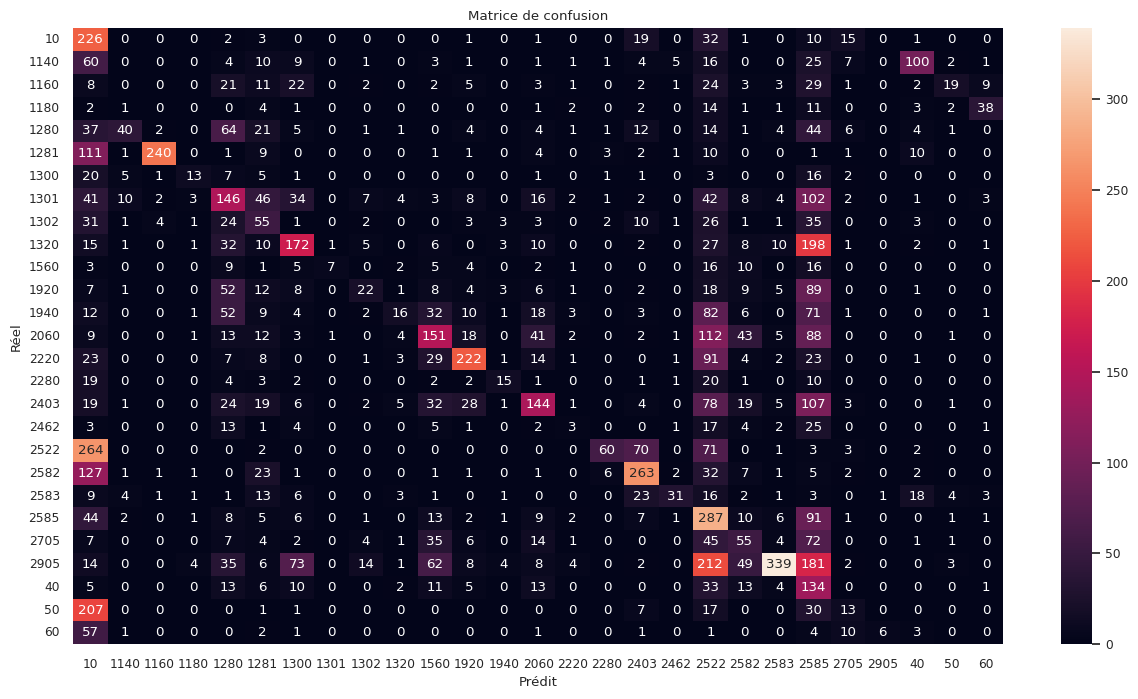

In [ ]:
cm = pd.crosstab(y_test,test_pred_class,rownames=["réel"],colnames=["prédit"])
plot_confusion_matrix(np.array(cm))



todo: comment

## Résumé

Nous avons atteint la fin de l'évaluation de cette modélisation. Affichons le rapport du modèle

In [ ]:
reporting_df.loc[model_id].T

model_name                                                          Modèle 1.1.4
dataset_source                 output/data-preprocessing-resampling/df_{train...
dataset_resampled                                                           True
image_dataset_source             output/data-preprocessing-images/images_pre.zip
image_dataset_zoomed                                                        True
train_size                                                               87652.0
image_size                                                                 224.0
image_color_rgb                                                             True
batch_size                                                                  64.0
image_data_generator_params    {'rescale': 0.00392156862745098, 'preprocessin...
start_lr                                                                   0.001
last_lr                                                                    0.001
optimizer                   

# Modélisation 1.5

Ici, on test le modèle précédent avec un dropout plus élevé (0.4 au lieu de 0.2) pour tenter de réduire l'overfitting.

Changeons la variables **model_id** pour qu'elle corresponde au modèle en cours

In [ ]:
model_id = 115

## Import des données

On importe donc les images zoomées qui ont été produites par le notebook **data_preprocessing_images**

In [ ]:
image_path = import_images("output/data-preprocessing-images/images_pre.zip","/tmp/rakuten-images-2")

extracting images from drive into colab's session storage... (about 1 min)


On charge maintenant le csv des données ré-équilibrées par le notebook **data_preprocessing_resampling**. Ce notebook étant executé à partir des données en sortie de **data_preprocessing_images**, il contient également la colonne **imagefile**.

Nous n'aurons pas besoin de refaire le split des données d'entrainement, **data_preprocessing_resampling** s'en étant déjà chargé. Nous avons juste à charger les trois fichiers qui constituent sa sortie:
* **df_train.csv**: L'ensemble d'entrainement
* **df_val.csv**: L'ensemble de validation
* **df_test.csv**: L'ensemble de test

In [ ]:
df_train = pd.read_csv("output/data-preprocessing-resampling/df_train.csv", index_col=0)
df_val = pd.read_csv("output/data-preprocessing-resampling/df_val.csv")
df_test = pd.read_csv("output/data-preprocessing-resampling/df_test.csv")
df_val.head()

,index,productid,imageid,text,lang,text_fr,imagefile,prdtypecode
0,64448,1951685748,1317996370,Linxor - Bâche à Bulles 300 microns Piscine 3m...,fr,Linxor - Bâche à Bulles 300 microns Piscine 3m...,2583/image_1317996370_product_1951685748.jpg,2583
1,37973,159494381,1029666610,Kit piscine autoportante Easy Set Ø 305 x 076m -,fr,Kit piscine autoportante Easy Set Ø 305 x 076m -,2583/image_1029666610_product_159494381.jpg,2583
2,73967,4011564183,1276163958,Kayak Gonflable Betta Hm K0 Biplace Et Ses Acc...,fr,Kayak Gonflable Betta Hm K0 Biplace Et Ses Acc...,1302/image_1276163958_product_4011564183.jpg,1302
3,33180,3797074222,1246071438,Mini Coloré En Plastique Pot De Fleurs Succule...,fr,Mini Coloré En Plastique Pot De Fleurs Succule...,2582/image_1246071438_product_3797074222.jpg,2582
4,26659,4157458648,1303079928,Modèle De Voiturerc Buggy Truck Chassis Body L...,fr,Modèle De Voiturerc Buggy Truck Chassis Body L...,1300/image_1303079928_product_4157458648.jpg,1300


## Preprocessing

Cette fois-ci, on va se contenter de créer les variables **X** et **y** correspondant aux différents ensembles, puis on va réduire leur nombre d'observations pour qu'il soit similaire à ce qu'on a utilisé pour les premières modélisations

In [ ]:
X_train = df_train.drop("prdtypecode",axis=1)
y_train = df_train["prdtypecode"]

X_validation = df_val.drop("prdtypecode",axis=1)
y_validation = df_val["prdtypecode"]

X_test = df_test.drop("prdtypecode",axis=1)
y_test = df_test["prdtypecode"]

On réduit l'ensemble d'entrainement pour qu'il contienne environ 50% des données de départ. le paramètre stratify étant égal à **y_train**, le nombre d'occurences de chaque classe en sortie devrait être équilibré

In [ ]:
target_train_size = int(len(X_train))
print("Target train size is", target_train_size)
train_split_rate = 0.2
X_train, X_none, y_train, y_none = train_test_split(X_train,y_train,test_size=train_split_rate,random_state = random_state,
                                                    shuffle=True,stratify=y_train)
print("X_train length is now",len(X_train))

Target train size is 109566
X_train length is now 87652


Confirmons que les classes sont toujours équilibrées après la réduction.

In [ ]:
y_train.value_counts()

2220    3247
2522    3247
1302    3247
10      3247
2060    3247
1560    3247
1320    3247
2585    3247
1300    3247
1281    3247
2582    3246
1301    3246
1940    3246
50      3246
40      3246
2403    3246
2905    3246
1280    3246
2462    3246
1920    3246
60      3246
2583    3246
1140    3246
1180    3246
2280    3246
2705    3246
1160    3246
Name: prdtypecode, dtype: int64

C'est bien le cas

On va laisser les set de test et de validation inchangés car ils sont déjà calibré à 10% des données

## Initialisation du rapport de modéle

Si un fichier **model_reporting.csv** existe, on le charge. Autrement, on en crée un nouveau.

In [ ]:
Path(output_dir).mkdir(parents=True, exist_ok=True)
try:
  reporting_df = load_reporting_df()
  print("loaded ",output_dir+"/model_reporting.csv")
except FileNotFoundError:
  reporting_df = create_reporting_df()
  print(output_dir+"/model_reporting.csv","not found. creating one")


loaded  output/data-modeling-images-2/model_reporting.csv


In [ ]:
reporting_df.head()

,model_name,dataset_source,dataset_resampled,image_dataset_source,image_dataset_zoomed,train_size,image_size,image_color_rgb,batch_size,image_data_generator_params,...,fit_complete,f1_score,val_f1_score,test_f1_score,accuracy,val_accuracy,test_accuracy,loss,val_loss,remarks
model_id,,,,,,,,,,,,,,,,,,,,,
0,Example model,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,42458.0,300.0,True,32.0,"{'rescale': 0.00392156862745098, 'shear_range'...",...,True,0.420000,0.370000,0.350000,0.570000,0.390000,0.410000,1.567000,2.657000,Ceci n'est pas un vrai modèle. C'est juste un ...
112,Modèle 1.1.2,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,32869.0,224.0,True,32.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.223995,0.159299,0.153432,0.239699,0.169811,0.153432,2.552496,2.893241,NaN
111,Modèle 1.1.1,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,21913.0,224.0,True,64.0,"{'rescale': 0.00392156862745098, 'preprocessin...",...,True,0.491908,0.411804,0.416277,0.495126,0.402107,0.416277,1.654593,2.027163,NaN
113,Modèle 1.1.3,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,27391.0,224.0,True,64.0,"{'rescale': 0.00392156862745098, 'preprocessin...",...,True,0.329768,0.293019,0.290177,0.340872,0.307647,0.290177,2.190135,2.296956,NaN
1111,Modèle 1.1.1.1,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,21913.0,224.0,True,64.0,"{'rescale': 0.00392156862745098, 'preprocessin...",...,True,0.510486,0.400509,0.405420,0.514532,0.388139,0.405420,1.590917,2.166416,NaN


Ajoutons une ligne correspondant à notre modèle et commençons à renseigner ses informations.

In [ ]:
add_reporting_line(model_id,"Modèle 1.1.5")

On peut déja renseigner les informations sur les données sources qu'on utilise

In [ ]:

update_reporting_line(model_id,{
    "dataset_source": "output/data-preprocessing-resampling/df_{train,val,test}.zip",
    "dataset_resampled": True,
    "image_dataset_source" : "output/data-preprocessing-images/images_pre.zip",
    "image_dataset_zoomed" : True,
    "train_size": len(X_train),
})

## Générateurs d'images

Commençons par créer une liste ordonnée des classes que l'on va fournir aux générateurs. Plus tard cette liste nous servira à retrouver les classes correspondant aux prédictions car la methode **predict** de keras retourne une matrice dont les colonnes correspondent aux classes dans l'ordre auquel on les a fourni.

In [ ]:
classes_keras = list(np.sort(np.array(df_train["prdtypecode"].unique(),dtype="str")))


On va reprendre ici les même générateurs d'image que pour la modélisation 1.1. On se contente de rappeler leur méthode **flow_from_dataframe** pour obtenir une instance adaptée au nouveau jeu de données.

On pense quand même à sauvegarder dans le rapport les paramètres de **ImageDataGenerator** pour le modèle en cours.

In [ ]:
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=5,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

update_reporting_line(model_id, {
    "image_data_generator_params" : {
      "rescale":1./255,
      'preprocessing_function':'preprocess_input',
      "rotation_range":20,
      "width_shift_range":0.2,
      "height_shift_range":0.2,
      "shear_range":5,
      "zoom_range":0.1,
      "horizontal_flip":True,
      "vertical_flip":True,
      "fill_mode":'nearest'
      }
})

batch_size = 64
target_img_size = (224,224,3)
color_mode = "rgb"

update_reporting_line(model_id, {
    "batch_size":batch_size,
    "image_size": target_img_size[0],
    "image_color_rgb": True
})

train_generator = train_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_train['imagefile'],"prdtypecode": y_train.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 87652 validated image filenames belonging to 27 classes.


In [ ]:
validation_data_generator = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input
)

validation_generator = validation_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_validation['imagefile'],"prdtypecode": y_validation.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 8492 validated image filenames belonging to 27 classes.


In [ ]:
test_data_generator = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input,
)

test_generator = test_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_test['imagefile'],"prdtypecode": y_test.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras,
    shuffle=False
)

Found 8492 validated image filenames belonging to 27 classes.


## Création du model

In [ ]:
def build_model():
    resnet_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Ajouter des couches supplémentaires pour l'adaptation au problème de classification
    x = GlobalAveragePooling2D()(resnet_model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Couche de sortie avec le nombre de classes dans votre ensemble de données (27 classes)
    output_layer = Dense(27, activation='softmax')(x)

    # Créer un nouveau modèle en spécifiant les entrées et la sortie
    custom_model = Model(inputs=resnet_model.input, outputs=output_layer)

    # Visualiser la structure du modèle
    custom_model.summary()

    return custom_model

S'il n'y a pas encore de modèle enregistré, on le construit puis on le compile en veillant à passer notre métrique **w_f1_score** personnalisée.
On conserve le même taux d'apprentissage de départ que dans la modélisation 1.1

In [ ]:
# model = load_saved_model(model_id)
start_lr = 0.001
print("build model")
model = build_model()
model.compile(
    optimizer=Adam(learning_rate=start_lr),
    loss='categorical_crossentropy',
    metrics=['accuracy', w_f1_score]
)
update_reporting_line(model_id,{
    "start_lr": start_lr,
    "optimizer": "adam",
})

build model
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                            

## Entrainement du model

On procéde à l'entrainement du modèle de la même façon que lors de la modélisation 1.1. Là encore, on réutilise les mêmes paramètres.

In [ ]:
target_epochs = 10
if not get_reporting_value(model_id,"fit_complete",False):
  update_reporting_line(model_id,{
      "target_epochs": target_epochs
  })
  training_history = model.fit(
      train_generator,
      validation_data=validation_generator,
      steps_per_epoch=train_generator.samples // batch_size,
      validation_steps = validation_generator.samples // batch_size,
      epochs=target_epochs - int(get_reporting_value(model_id,"last_epoch",0)),
      verbose=1,
      callbacks=[LogBest(model_id),early_stopping]
  )
  update_reporting_line(model_id,{"fit_complete":True})
else:
  print("No need to train model")
  training_history = None

Epoch 1/10
1369/1369 [==============================] - ETA: 0s - loss: 2.6803 - accuracy: 0.2060 - w_f1_score: 0.1887
Found better model with val_f1_score=0.23
save model  115 to  output/data-modeling-images-2/model-115.keras
1369/1369 [==============================] - 1687s 1s/step - loss: 2.6803 - accuracy: 0.2060 - w_f1_score: 0.1887 - val_loss: 2.5526 - val_accuracy: 0.2488 - val_w_f1_score: 0.2298
Epoch 2/10
1369/1369 [==============================] - ETA: 0s - loss: 2.2476 - accuracy: 0.3339 - w_f1_score: 0.3205
Found better model with val_f1_score=0.31
save model  115 to  output/data-modeling-images-2/model-115.keras
1369/1369 [==============================] - 1671s 1s/step - loss: 2.2476 - accuracy: 0.3339 - w_f1_score: 0.3205 - val_loss: 2.3472 - val_accuracy: 0.3215 - val_w_f1_score: 0.3096
Epoch 3/10
1369/1369 [==============================] - 1685s 1s/step - loss: 2.0637 - accuracy: 0.3849 - w_f1_score: 0.3740 - val_loss: 2.5316 - val_accuracy: 0.2623 - val_w_f1_score:

## Evaluation du modèle

Si un entrainement a eu lieu au cours de cette execution du notebook, on recharge le meilleur modèle qu'on a trouvé

In [ ]:
if training_history != None:
  #if fit wad called, make sure to load best saved model, otherwise it's already loaded
  model = load_saved_model(model_id)


Load previous model from output/data-modeling-images-2/model-115.keras


On teste le modèle sur l'ensemble de test

In [ ]:
test_pred = model.predict(test_generator,verbose=1)

133/133 [==============================] - 52s 381ms/step


On doit convertir le resulat de **predict** depuis le format renvoyés par keras qui est une matrice de probabilités avec les classes en colonnes et les observations du jeu de test en lignes en un tableau à 1 dimension contenant les classes prédites pour chaque observation.

Pour cela, on extrait pour chaque observation l'index de la probabilité max de prédiction. On utilise ensuite cet index pour retrouver la classe correspondante dans **classes_keras**, la liste des classes telle qu'on la fourni à keras.

In [ ]:
test_pred_class = np.argmax(test_pred,axis=1)
test_pred_class = [classes_keras[c] for c in test_pred_class]

A partir des classes prédites et des observations réelles, on calcul, le score f1 ainsi que l'accuracy de notre modèle, toujours sur le jeu de test.

On enregistre ces infos dans le rapport.

In [ ]:
f1_weighted = f1_score(y_test.astype("str"),test_pred_class,average="weighted")
accuracy = accuracy_score(y_test.astype("str"),test_pred_class)
update_reporting_line(model_id,{
    "test_f1_score":f1_weighted,
    "test_accuracy":f1_weighted
})

print("f1_score on test dataset=%.2f" % f1_weighted)
print("accuracy on test dataset=%.2f" % accuracy)

f1_score on test dataset=0.45
accuracy on test dataset=0.43


On récupère l'historique d'entrainement complet gràce à **get_full_training_history** qu'on va enregistrer puis on affiche deux graphiques:

* L'évolution de l'accuracy et du score f1 pendant en fonction des époques
* L'évolution des indicateurs de perte **loss** et **val_loss**

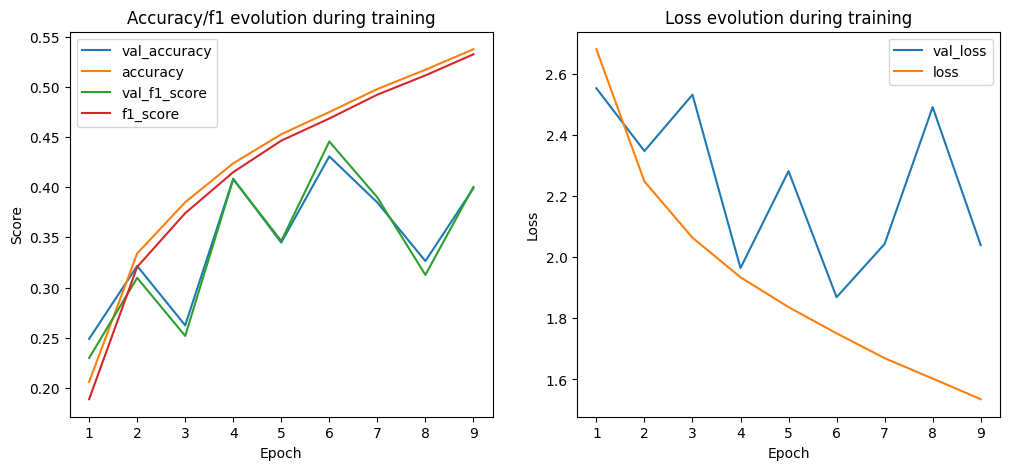

In [ ]:
history = get_full_training_history(model_id,training_history)
if history != None:
  save_training_history(model_id,history)
  #to avoid concat of same history when re-executing this cell
  training_history = None
  plot_training_history(history)

todo: comment

On va maintenant afficher le rapport de classification qui va nous donner une vision détaillée par classe des scores de prédiction.

In [ ]:

print(classification_report(y_test.astype("str"),test_pred_class))


              precision    recall  f1-score   support

          10       0.38      0.32      0.35       311
        1140       0.46      0.38      0.42       267
        1160       0.85      0.86      0.85       396
        1180       0.32      0.16      0.21        76
        1280       0.49      0.10      0.17       487
        1281       0.26      0.30      0.28       207
        1300       0.58      0.34      0.43       505
        1301       0.22      0.48      0.30        81
        1302       0.14      0.28      0.19       249
        1320       0.32      0.22      0.26       324
        1560       0.68      0.22      0.33       507
        1920       0.74      0.67      0.70       431
        1940       0.29      0.72      0.41        81
        2060       0.41      0.30      0.35       499
        2220       0.12      0.17      0.14        82
        2280       0.72      0.66      0.68       476
        2403       0.65      0.47      0.55       477
        2462       0.30    

todo: comment

Affichons la matrice de confusion sous forme de heatmap pour plus de lisibilité.

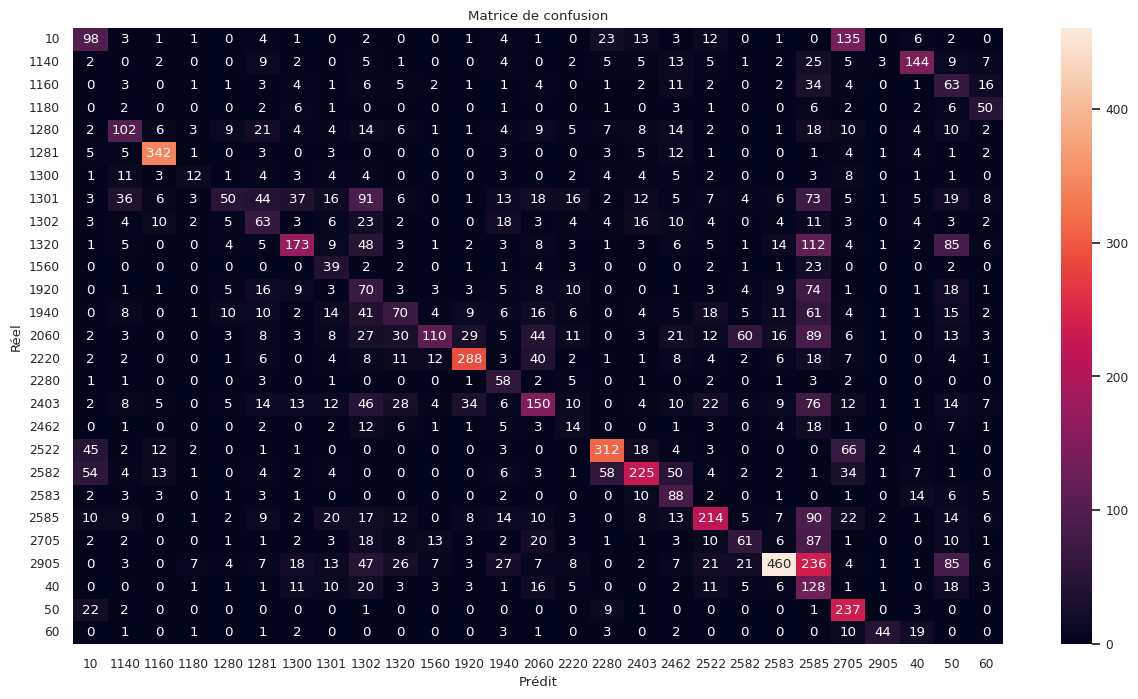

In [ ]:
cm = pd.crosstab(y_test,test_pred_class,rownames=["réel"],colnames=["prédit"])
plot_confusion_matrix(np.array(cm))



todo: comment

## Résumé

Nous avons atteint la fin de l'évaluation de cette modélisation. Affichons le rapport du modèle

In [ ]:
reporting_df.loc[model_id].T

model_name                                                          Modèle 1.1.5
dataset_source                 output/data-preprocessing-resampling/df_{train...
dataset_resampled                                                           True
image_dataset_source             output/data-preprocessing-images/images_pre.zip
image_dataset_zoomed                                                        True
train_size                                                               87652.0
image_size                                                                 224.0
image_color_rgb                                                             True
batch_size                                                                  64.0
image_data_generator_params    {'rescale': 0.00392156862745098, 'preprocessin...
start_lr                                                                   0.001
last_lr                                                                    0.001
optimizer                   

# Modélisation 1.7

Ici, on test le modèle précédent avec un dropout plus élevé (0.4 au lieu de 0.2) pour tenter de réduire l'overfitting.

Changeons la variables **model_id** pour qu'elle corresponde au modèle en cours

In [ ]:
model_id = 117

## Import des données

On importe donc les images zoomées qui ont été produites par le notebook **data_preprocessing_images**

In [ ]:
image_path = import_images("output/data-preprocessing-images/images_pre.zip","/tmp/rakuten-images-2")

extracting images from drive into colab's session storage... (about 1 min)


On charge maintenant le csv des données ré-équilibrées par le notebook **data_preprocessing_resampling**. Ce notebook étant executé à partir des données en sortie de **data_preprocessing_images**, il contient également la colonne **imagefile**.

Nous n'aurons pas besoin de refaire le split des données d'entrainement, **data_preprocessing_resampling** s'en étant déjà chargé. Nous avons juste à charger les trois fichiers qui constituent sa sortie:
* **df_train.csv**: L'ensemble d'entrainement
* **df_val.csv**: L'ensemble de validation
* **df_test.csv**: L'ensemble de test

In [ ]:
df_train = pd.read_csv("output/data-preprocessing-resampling/df_train.csv", index_col=0)
df_val = pd.read_csv("output/data-preprocessing-resampling/df_val.csv")
df_test = pd.read_csv("output/data-preprocessing-resampling/df_test.csv")
df_val.head()

,index,productid,imageid,text,lang,text_fr,imagefile,prdtypecode
0,64448,1951685748,1317996370,Linxor - Bâche à Bulles 300 microns Piscine 3m...,fr,Linxor - Bâche à Bulles 300 microns Piscine 3m...,2583/image_1317996370_product_1951685748.jpg,2583
1,37973,159494381,1029666610,Kit piscine autoportante Easy Set Ø 305 x 076m -,fr,Kit piscine autoportante Easy Set Ø 305 x 076m -,2583/image_1029666610_product_159494381.jpg,2583
2,73967,4011564183,1276163958,Kayak Gonflable Betta Hm K0 Biplace Et Ses Acc...,fr,Kayak Gonflable Betta Hm K0 Biplace Et Ses Acc...,1302/image_1276163958_product_4011564183.jpg,1302
3,33180,3797074222,1246071438,Mini Coloré En Plastique Pot De Fleurs Succule...,fr,Mini Coloré En Plastique Pot De Fleurs Succule...,2582/image_1246071438_product_3797074222.jpg,2582
4,26659,4157458648,1303079928,Modèle De Voiturerc Buggy Truck Chassis Body L...,fr,Modèle De Voiturerc Buggy Truck Chassis Body L...,1300/image_1303079928_product_4157458648.jpg,1300


## Preprocessing

Cette fois-ci, on va se contenter de créer les variables **X** et **y** correspondant aux différents ensembles, puis on va réduire leur nombre d'observations pour qu'il soit similaire à ce qu'on a utilisé pour les premières modélisations

In [ ]:
X_train = df_train.drop("prdtypecode",axis=1)
y_train = df_train["prdtypecode"]

X_validation = df_val.drop("prdtypecode",axis=1)
y_validation = df_val["prdtypecode"]

X_test = df_test.drop("prdtypecode",axis=1)
y_test = df_test["prdtypecode"]

On réduit l'ensemble d'entrainement pour qu'il contienne environ 50% des données de départ. le paramètre stratify étant égal à **y_train**, le nombre d'occurences de chaque classe en sortie devrait être équilibré

In [ ]:
target_train_size = int(len(X_train))
print("Target train size is", target_train_size)
train_split_rate = 0.2
X_train, X_none, y_train, y_none = train_test_split(X_train,y_train,test_size=train_split_rate,random_state = random_state,
                                                    shuffle=True,stratify=y_train)
print("X_train length is now",len(X_train))

Target train size is 109566
X_train length is now 87652


Confirmons que les classes sont toujours équilibrées après la réduction.

In [ ]:
y_train.value_counts()

2220    3247
2522    3247
1302    3247
10      3247
2060    3247
1560    3247
1320    3247
2585    3247
1300    3247
1281    3247
2582    3246
1301    3246
1940    3246
50      3246
40      3246
2403    3246
2905    3246
1280    3246
2462    3246
1920    3246
60      3246
2583    3246
1140    3246
1180    3246
2280    3246
2705    3246
1160    3246
Name: prdtypecode, dtype: int64

C'est bien le cas

On va laisser les set de test et de validation inchangés car ils sont déjà calibré à 10% des données

## Initialisation du rapport de modéle

Si un fichier **model_reporting.csv** existe, on le charge. Autrement, on en crée un nouveau.

In [ ]:
Path(output_dir).mkdir(parents=True, exist_ok=True)
try:
  reporting_df = load_reporting_df()
  print("loaded ",output_dir+"/model_reporting.csv")
except FileNotFoundError:
  reporting_df = create_reporting_df()
  print(output_dir+"/model_reporting.csv","not found. creating one")


loaded  output/data-modeling-images-2/model_reporting.csv


In [ ]:
reporting_df.head()

,model_name,dataset_source,dataset_resampled,image_dataset_source,image_dataset_zoomed,train_size,image_size,image_color_rgb,batch_size,image_data_generator_params,...,fit_complete,f1_score,val_f1_score,test_f1_score,accuracy,val_accuracy,test_accuracy,loss,val_loss,remarks
model_id,,,,,,,,,,,,,,,,,,,,,
0,Example model,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,42458.0,300.0,True,32.0,"{'rescale': 0.00392156862745098, 'shear_range'...",...,True,0.420000,0.370000,0.350000,0.570000,0.390000,0.410000,1.567000,2.657000,Ceci n'est pas un vrai modèle. C'est juste un ...
112,Modèle 1.1.2,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,32869.0,224.0,True,32.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.223995,0.159299,0.153432,0.239699,0.169811,0.153432,2.552496,2.893241,NaN
111,Modèle 1.1.1,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,21913.0,224.0,True,64.0,"{'rescale': 0.00392156862745098, 'preprocessin...",...,True,0.491908,0.411804,0.416277,0.495126,0.402107,0.416277,1.654593,2.027163,NaN
113,Modèle 1.1.3,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,27391.0,224.0,True,64.0,"{'rescale': 0.00392156862745098, 'preprocessin...",...,True,0.329768,0.293019,0.290177,0.340872,0.307647,0.290177,2.190135,2.296956,NaN
1111,Modèle 1.1.1.1,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,21913.0,224.0,True,64.0,"{'rescale': 0.00392156862745098, 'preprocessin...",...,True,0.510486,0.400509,0.405420,0.514532,0.388139,0.405420,1.590917,2.166416,NaN


Ajoutons une ligne correspondant à notre modèle et commençons à renseigner ses informations.

In [ ]:
add_reporting_line(model_id,"Modèle 1.1.7")

On peut déja renseigner les informations sur les données sources qu'on utilise

In [ ]:

update_reporting_line(model_id,{
    "dataset_source": "output/data-preprocessing-resampling/df_{train,val,test}.zip",
    "dataset_resampled": True,
    "image_dataset_source" : "output/data-preprocessing-images/images_pre.zip",
    "image_dataset_zoomed" : True,
    "train_size": len(X_train),
})

## Générateurs d'images

Commençons par créer une liste ordonnée des classes que l'on va fournir aux générateurs. Plus tard cette liste nous servira à retrouver les classes correspondant aux prédictions car la methode **predict** de keras retourne une matrice dont les colonnes correspondent aux classes dans l'ordre auquel on les a fourni.

In [ ]:
classes_keras = list(np.sort(np.array(df_train["prdtypecode"].unique(),dtype="str")))


On va reprendre ici les même générateurs d'image que pour la modélisation 1.1. On se contente de rappeler leur méthode **flow_from_dataframe** pour obtenir une instance adaptée au nouveau jeu de données.

On pense quand même à sauvegarder dans le rapport les paramètres de **ImageDataGenerator** pour le modèle en cours.

In [ ]:
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=5,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

update_reporting_line(model_id, {
    "image_data_generator_params" : {
      "rescale":1./255,
      'preprocessing_function':'preprocess_input',
      "rotation_range":20,
      "width_shift_range":0.2,
      "height_shift_range":0.2,
      "shear_range":5,
      "zoom_range":0.1,
      "horizontal_flip":True,
      "vertical_flip":True,
      "fill_mode":'nearest'
      }
})

batch_size = 32
target_img_size = (224,224,3)
color_mode = "rgb"

update_reporting_line(model_id, {
    "batch_size":batch_size,
    "image_size": target_img_size[0],
    "image_color_rgb": True
})

train_generator = train_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_train['imagefile'],"prdtypecode": y_train.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 87652 validated image filenames belonging to 27 classes.


In [ ]:
validation_data_generator = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input
)

validation_generator = validation_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_validation['imagefile'],"prdtypecode": y_validation.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 8492 validated image filenames belonging to 27 classes.


In [ ]:
test_data_generator = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input,
)

test_generator = test_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_test['imagefile'],"prdtypecode": y_test.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras,
    shuffle=False
)

Found 8492 validated image filenames belonging to 27 classes.


## Création du model

In [ ]:
def build_model():
    resnet_model = tf.keras.applications.ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in resnet_model.layers:
      layer.trainable = False

    for layer in resnet_model.layers[-20:]:
      layer.trainable = True

    # Ajouter des couches supplémentaires pour l'adaptation au problème de classification
    x = GlobalAveragePooling2D()(resnet_model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)

    # Couche de sortie avec le nombre de classes dans votre ensemble de données (27 classes)
    output_layer = Dense(27, activation='softmax')(x)

    # Créer un nouveau modèle en spécifiant les entrées et la sortie
    custom_model = Model(inputs=resnet_model.input, outputs=output_layer)

    return custom_model

In [ ]:
build_model().summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

S'il n'y a pas encore de modèle enregistré, on le construit puis on le compile en veillant à passer notre métrique **w_f1_score** personnalisée.
On conserve le même taux d'apprentissage de départ que dans la modélisation 1.1

In [ ]:
model = load_saved_model(model_id)
start_lr = 0.0001
print("build model")
# model = build_model()
model.compile(
    optimizer=Adam(learning_rate=start_lr),
    loss='categorical_crossentropy',
    metrics=['accuracy', w_f1_score]
)

# Visualiser la structure du modèle
    custom_model.summary()

update_reporting_line(model_id,{
    "start_lr": start_lr,
    "optimizer": "adam",
})

Load previous model from output/data-modeling-images-2/model-117.keras


## Entrainement du model

On procéde à l'entrainement du modèle de la même façon que lors de la modélisation 1.1. Là encore, on réutilise les mêmes paramètres.

In [ ]:
target_epochs = 10
if not get_reporting_value(model_id,"fit_complete",False):
  update_reporting_line(model_id,{
      "target_epochs": target_epochs
  })
  training_history = model.fit(
      train_generator,
      validation_data=validation_generator,
      steps_per_epoch=train_generator.samples // batch_size,
      validation_steps = validation_generator.samples // batch_size,
      epochs=target_epochs - int(get_reporting_value(model_id,"last_epoch",0)),
      verbose=1,
      callbacks=[LogBest(model_id),early_stopping]
  )
  update_reporting_line(model_id,{"fit_complete":True})
else:
  print("No need to train model")
  training_history = None

No need to train model


## Evaluation du modèle

Si un entrainement a eu lieu au cours de cette execution du notebook, on recharge le meilleur modèle qu'on a trouvé

In [ ]:
if training_history == None:
  #if fit wad called, make sure to load best saved model, otherwise it's already loaded
  model = load_saved_model(model_id)


Load previous model from output/data-modeling-images-2/model-117.keras


On teste le modèle sur l'ensemble de test

In [ ]:
test_pred = model.predict(test_generator,verbose=1)

266/266 [==============================] - 76s 258ms/step


On doit convertir le resulat de **predict** depuis le format renvoyés par keras qui est une matrice de probabilités avec les classes en colonnes et les observations du jeu de test en lignes en un tableau à 1 dimension contenant les classes prédites pour chaque observation.

Pour cela, on extrait pour chaque observation l'index de la probabilité max de prédiction. On utilise ensuite cet index pour retrouver la classe correspondante dans **classes_keras**, la liste des classes telle qu'on la fourni à keras.

In [ ]:
test_pred_class = np.argmax(test_pred,axis=1)
test_pred_class = [classes_keras[c] for c in test_pred_class]

A partir des classes prédites et des observations réelles, on calcul, le score f1 ainsi que l'accuracy de notre modèle, toujours sur le jeu de test.

On enregistre ces infos dans le rapport.

In [ ]:
f1_weighted = f1_score(y_test.astype("str"),test_pred_class,average="weighted")
accuracy = accuracy_score(y_test.astype("str"),test_pred_class)
update_reporting_line(model_id,{
    "test_f1_score":f1_weighted,
    "test_accuracy":f1_weighted
})

print("f1_score on test dataset=%.2f" % f1_weighted)
print("accuracy on test dataset=%.2f" % accuracy)

f1_score on test dataset=0.59
accuracy on test dataset=0.58


On récupère l'historique d'entrainement complet gràce à **get_full_training_history** qu'on va enregistrer puis on affiche deux graphiques:

* L'évolution de l'accuracy et du score f1 pendant en fonction des époques
* L'évolution des indicateurs de perte **loss** et **val_loss**

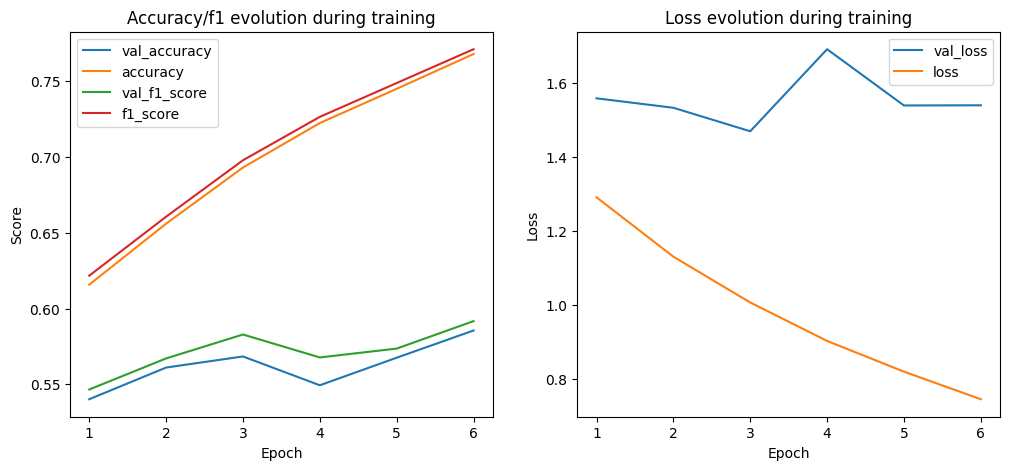

In [ ]:
history = get_full_training_history(model_id,training_history)
if history != None:
  save_training_history(model_id,history)
  #to avoid concat of same history when re-executing this cell
  training_history = None
  plot_training_history(history)

todo: comment

On va maintenant afficher le rapport de classification qui va nous donner une vision détaillée par classe des scores de prédiction.

In [ ]:

print(classification_report(y_test.astype("str"),test_pred_class))


              precision    recall  f1-score   support

          10       0.39      0.68      0.50       311
        1140       0.68      0.49      0.57       267
        1160       0.85      0.91      0.88       396
        1180       0.40      0.30      0.35        76
        1280       0.47      0.21      0.29       487
        1281       0.22      0.46      0.29       207
        1300       0.66      0.68      0.67       505
        1301       0.63      0.56      0.59        81
        1302       0.38      0.45      0.41       249
        1320       0.43      0.47      0.45       324
        1560       0.67      0.47      0.56       507
        1920       0.82      0.78      0.80       431
        1940       0.60      0.73      0.66        81
        2060       0.54      0.42      0.47       499
        2220       0.32      0.23      0.27        82
        2280       0.78      0.66      0.71       476
        2403       0.77      0.49      0.60       477
        2462       0.70    

todo: comment

Affichons la matrice de confusion sous forme de heatmap pour plus de lisibilité.

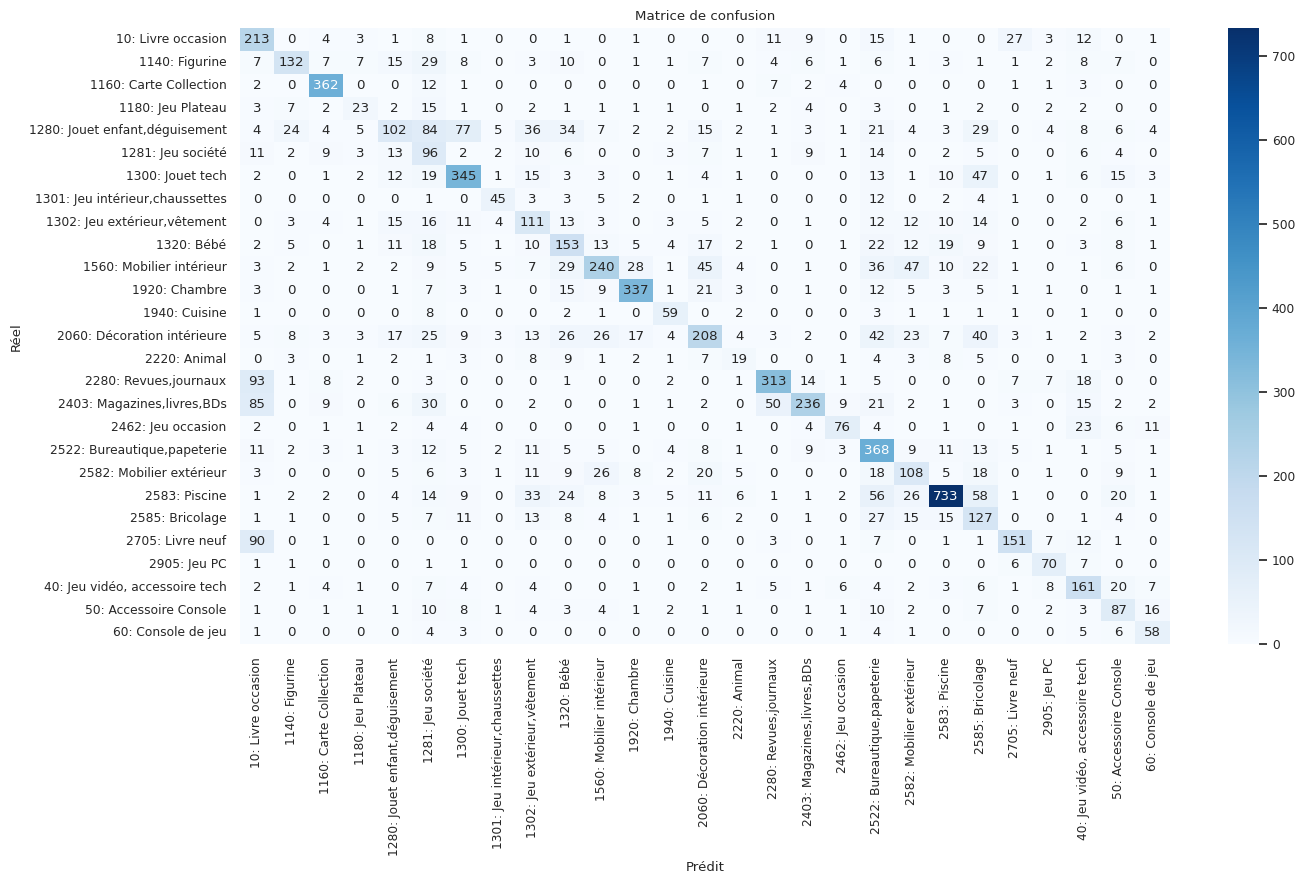

In [ ]:
cm = pd.crosstab(y_test.astype("str"),test_pred_class,rownames=["réel"],colnames=["prédit"])
plot_confusion_matrix(np.array(cm))



todo: comment

## Résumé

Nous avons atteint la fin de l'évaluation de cette modélisation. Affichons le rapport du modèle

In [ ]:
reporting_df.loc[model_id].T

model_name                                                          Modèle 1.1.7
dataset_source                 output/data-preprocessing-resampling/df_{train...
dataset_resampled                                                           True
image_dataset_source             output/data-preprocessing-images/images_pre.zip
image_dataset_zoomed                                                        True
train_size                                                               87652.0
image_size                                                                 224.0
image_color_rgb                                                             True
batch_size                                                                  32.0
image_data_generator_params    {'rescale': 0.00392156862745098, 'preprocessin...
start_lr                                                                  0.0001
last_lr                                                                   0.0001
optimizer                   

# Modélisation 1.8

Ici, on test le modèle précédent avec un dropout plus élevé (0.4 au lieu de 0.2) pour tenter de réduire l'overfitting.

Changeons la variables **model_id** pour qu'elle corresponde au modèle en cours

In [ ]:
model_id = 118

## Import des données

On importe donc les images zoomées qui ont été produites par le notebook **data_preprocessing_images**

In [ ]:
image_path = import_images("output/data-preprocessing-images/images_pre.zip","/tmp/rakuten-images-2")

images already imported from drive


On charge maintenant le csv des données ré-équilibrées par le notebook **data_preprocessing_resampling**. Ce notebook étant executé à partir des données en sortie de **data_preprocessing_images**, il contient également la colonne **imagefile**.

Nous n'aurons pas besoin de refaire le split des données d'entrainement, **data_preprocessing_resampling** s'en étant déjà chargé. Nous avons juste à charger les trois fichiers qui constituent sa sortie:
* **df_train.csv**: L'ensemble d'entrainement
* **df_val.csv**: L'ensemble de validation
* **df_test.csv**: L'ensemble de test

In [ ]:
df_train = pd.read_csv("output/data-preprocessing-resampling/df_train.csv", index_col=0)
df_val = pd.read_csv("output/data-preprocessing-resampling/df_val.csv")
df_test = pd.read_csv("output/data-preprocessing-resampling/df_test.csv")
df_val.head()

,index,productid,imageid,text,lang,text_fr,imagefile,prdtypecode
0,64448,1951685748,1317996370,Linxor - Bâche à Bulles 300 microns Piscine 3m...,fr,Linxor - Bâche à Bulles 300 microns Piscine 3m...,2583/image_1317996370_product_1951685748.jpg,2583
1,37973,159494381,1029666610,Kit piscine autoportante Easy Set Ø 305 x 076m -,fr,Kit piscine autoportante Easy Set Ø 305 x 076m -,2583/image_1029666610_product_159494381.jpg,2583
2,73967,4011564183,1276163958,Kayak Gonflable Betta Hm K0 Biplace Et Ses Acc...,fr,Kayak Gonflable Betta Hm K0 Biplace Et Ses Acc...,1302/image_1276163958_product_4011564183.jpg,1302
3,33180,3797074222,1246071438,Mini Coloré En Plastique Pot De Fleurs Succule...,fr,Mini Coloré En Plastique Pot De Fleurs Succule...,2582/image_1246071438_product_3797074222.jpg,2582
4,26659,4157458648,1303079928,Modèle De Voiturerc Buggy Truck Chassis Body L...,fr,Modèle De Voiturerc Buggy Truck Chassis Body L...,1300/image_1303079928_product_4157458648.jpg,1300


## Preprocessing

Cette fois-ci, on va se contenter de créer les variables **X** et **y** correspondant aux différents ensembles, puis on va réduire leur nombre d'observations pour qu'il soit similaire à ce qu'on a utilisé pour les premières modélisations

In [ ]:
X_train = df_train.drop("prdtypecode",axis=1)
y_train = df_train["prdtypecode"]

X_validation = df_val.drop("prdtypecode",axis=1)
y_validation = df_val["prdtypecode"]

X_test = df_test.drop("prdtypecode",axis=1)
y_test = df_test["prdtypecode"]

On réduit l'ensemble d'entrainement pour qu'il contienne environ 50% des données de départ. le paramètre stratify étant égal à **y_train**, le nombre d'occurences de chaque classe en sortie devrait être équilibré

In [ ]:
target_train_size = int(len(X_train))
print("Target train size is", target_train_size)
train_split_rate = 0.2
X_train, X_none, y_train, y_none = train_test_split(X_train,y_train,test_size=train_split_rate,random_state = random_state,
                                                    shuffle=True,stratify=y_train)
print("X_train length is now",len(X_train))

Target train size is 109566
X_train length is now 87652


Confirmons que les classes sont toujours équilibrées après la réduction.

In [ ]:
y_train.value_counts()

2220    3247
2522    3247
1302    3247
10      3247
2060    3247
1560    3247
1320    3247
2585    3247
1300    3247
1281    3247
2582    3246
1301    3246
1940    3246
50      3246
40      3246
2403    3246
2905    3246
1280    3246
2462    3246
1920    3246
60      3246
2583    3246
1140    3246
1180    3246
2280    3246
2705    3246
1160    3246
Name: prdtypecode, dtype: int64

C'est bien le cas

On va laisser les set de test et de validation inchangés car ils sont déjà calibré à 10% des données

## Initialisation du rapport de modéle

Si un fichier **model_reporting.csv** existe, on le charge. Autrement, on en crée un nouveau.

In [ ]:
Path(output_dir).mkdir(parents=True, exist_ok=True)
try:
  reporting_df = load_reporting_df()
  print("loaded ",output_dir+"/model_reporting.csv")
except FileNotFoundError:
  reporting_df = create_reporting_df()
  print(output_dir+"/model_reporting.csv","not found. creating one")


loaded  output/data-modeling-images-2/model_reporting.csv


In [6]:
reporting_df.head()

,model_name,dataset_source,dataset_resampled,image_dataset_source,image_dataset_zoomed,train_size,image_size,image_color_rgb,batch_size,image_data_generator_params,...,fit_complete,f1_score,val_f1_score,test_f1_score,accuracy,val_accuracy,test_accuracy,loss,val_loss,remarks
model_id,,,,,,,,,,,,,,,,,,,,,
0,Example model,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,42458.0,300.0,True,32.0,"{'rescale': 0.00392156862745098, 'shear_range'...",...,True,0.420000,0.370000,0.350000,0.570000,0.390000,0.410000,1.567000,2.657000,Ceci n'est pas un vrai modèle. C'est juste un ...
112,Modèle 1.1.2,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,32869.0,224.0,True,32.0,"{'rescale': 0.00392156862745098, 'rotation_ran...",...,True,0.223995,0.159299,0.153432,0.239699,0.169811,0.153432,2.552496,2.893241,NaN
111,Modèle 1.1.1,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,21913.0,224.0,True,64.0,"{'rescale': 0.00392156862745098, 'preprocessin...",...,True,0.491908,0.411804,0.416277,0.495126,0.402107,0.416277,1.654593,2.027163,NaN
113,Modèle 1.1.3,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,27391.0,224.0,True,64.0,"{'rescale': 0.00392156862745098, 'preprocessin...",...,True,0.329768,0.293019,0.290177,0.340872,0.307647,0.290177,2.190135,2.296956,NaN
1111,Modèle 1.1.1.1,output/data-preprocessing-resampling/df_{train...,True,output/data-preprocessing-images/images_pre.zip,True,21913.0,224.0,True,64.0,"{'rescale': 0.00392156862745098, 'preprocessin...",...,True,0.510486,0.400509,0.405420,0.514532,0.388139,0.405420,1.590917,2.166416,NaN


Ajoutons une ligne correspondant à notre modèle et commençons à renseigner ses informations.

In [ ]:
add_reporting_line(model_id,"Modèle 1.1.8")

On peut déja renseigner les informations sur les données sources qu'on utilise

In [ ]:

update_reporting_line(model_id,{
    "dataset_source": "output/data-preprocessing-resampling/df_{train,val,test}.zip",
    "dataset_resampled": True,
    "image_dataset_source" : "output/data-preprocessing-images/images_pre.zip",
    "image_dataset_zoomed" : True,
    "train_size": len(X_train),
})

## Générateurs d'images

Commençons par créer une liste ordonnée des classes que l'on va fournir aux générateurs. Plus tard cette liste nous servira à retrouver les classes correspondant aux prédictions car la methode **predict** de keras retourne une matrice dont les colonnes correspondent aux classes dans l'ordre auquel on les a fourni.

In [ ]:
classes_keras = list(np.sort(np.array(df_train["prdtypecode"].unique(),dtype="str")))


On va reprendre ici les même générateurs d'image que pour la modélisation 1.1. On se contente de rappeler leur méthode **flow_from_dataframe** pour obtenir une instance adaptée au nouveau jeu de données.

On pense quand même à sauvegarder dans le rapport les paramètres de **ImageDataGenerator** pour le modèle en cours.

In [ ]:
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=5,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

update_reporting_line(model_id, {
    "image_data_generator_params" : {
      "rescale":1./255,
      'preprocessing_function':'preprocess_input',
      "rotation_range":20,
      "width_shift_range":0.2,
      "height_shift_range":0.2,
      "shear_range":5,
      "zoom_range":0.1,
      "horizontal_flip":True,
      "vertical_flip":True,
      "fill_mode":'nearest'
      }
})

batch_size = 32
target_img_size = (224,224,3)
color_mode = "rgb"

update_reporting_line(model_id, {
    "batch_size":batch_size,
    "image_size": target_img_size[0],
    "image_color_rgb": True
})

train_generator = train_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_train['imagefile'],"prdtypecode": y_train.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 87652 validated image filenames belonging to 27 classes.


In [ ]:
validation_data_generator = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input
)

validation_generator = validation_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_validation['imagefile'],"prdtypecode": y_validation.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 8492 validated image filenames belonging to 27 classes.


In [ ]:
test_data_generator = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input,
)

test_generator = test_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_test['imagefile'],"prdtypecode": y_test.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras,
    shuffle=False
)

Found 8492 validated image filenames belonging to 27 classes.


## Création du model

In [ ]:
def build_model():
    resnet_model = tf.keras.applications.ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    #for layer in resnet_model.layers:
      #layer.trainable = False

    for layer in resnet_model.layers[-45:]:
      layer.trainable = True

    # Ajouter des couches supplémentaires pour l'adaptation au problème de classification
    x = GlobalAveragePooling2D()(resnet_model.output)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Couche de sortie avec le nombre de classes dans votre ensemble de données (27 classes)
    output_layer = Dense(27, activation='softmax')(x)

    # Créer un nouveau modèle en spécifiant les entrées et la sortie
    custom_model = Model(inputs=resnet_model.input, outputs=output_layer)

    return custom_model

In [ ]:
build_model().summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

S'il n'y a pas encore de modèle enregistré, on le construit puis on le compile en veillant à passer notre métrique **w_f1_score** personnalisée.
On conserve le même taux d'apprentissage de départ que dans la modélisation 1.1

In [ ]:
# model = load_saved_model(model_id)
start_lr = 0.0001
print("build model")
model = build_model()
model.compile(
    optimizer=Adam(learning_rate=start_lr),
    loss='categorical_crossentropy',
    metrics=['accuracy', w_f1_score]
)

# Visualiser la structure du modèle
# custom_model.summary()

update_reporting_line(model_id,{
    "start_lr": start_lr,
    "optimizer": "adam",
})
update_reporting_line(model_id, {"last_epoch": 0, "fit_complete": False})

build model


## Entrainement du model

On procéde à l'entrainement du modèle de la même façon que lors de la modélisation 1.1. Là encore, on réutilise les mêmes paramètres.

In [ ]:
target_epochs = 10
if not get_reporting_value(model_id,"fit_complete",False):
  update_reporting_line(model_id,{
      "target_epochs": target_epochs
  })
  training_history = model.fit(
      train_generator,
      validation_data=validation_generator,
      steps_per_epoch=train_generator.samples // batch_size,
      validation_steps = validation_generator.samples // batch_size,
      epochs=target_epochs - int(get_reporting_value(model_id,"last_epoch",0)),
      verbose=1,
      callbacks=[LogBest(model_id),early_stopping]
  )
  update_reporting_line(model_id,{"fit_complete":True})
else:
  print("No need to train model")
  training_history = None

Epoch 1/10
2739/2739 [==============================] - ETA: 0s - loss: 2.1697 - accuracy: 0.4027 - w_f1_score: 0.4110
Found better model with val_f1_score=0.51
save model  118 to  output/data-modeling-images-2/model-118.keras
2739/2739 [==============================] - 2640s 923ms/step - loss: 2.1697 - accuracy: 0.4027 - w_f1_score: 0.4110 - val_loss: 1.7021 - val_accuracy: 0.5048 - val_w_f1_score: 0.5149
Epoch 2/10
2739/2739 [==============================] - ETA: 0s - loss: 1.6164 - accuracy: 0.5268 - w_f1_score: 0.5394
Found better model with val_f1_score=0.53
save model  118 to  output/data-modeling-images-2/model-118.keras
2739/2739 [==============================] - 2497s 912ms/step - loss: 1.6164 - accuracy: 0.5268 - w_f1_score: 0.5394 - val_loss: 1.6263 - val_accuracy: 0.5218 - val_w_f1_score: 0.5274
Epoch 3/10
2739/2739 [==============================] - ETA: 0s - loss: 1.4001 - accuracy: 0.5823 - w_f1_score: 0.5943
Found better model with val_f1_score=0.56
save model  118 t

## Evaluation du modèle

Si un entrainement a eu lieu au cours de cette execution du notebook, on recharge le meilleur modèle qu'on a trouvé

In [ ]:
if training_history != None:
  #if fit wad called, make sure to load best saved model, otherwise it's already loaded
  model = load_saved_model(model_id)


NameError: name 'training_history' is not defined

On teste le modèle sur l'ensemble de test

In [ ]:
test_pred = model.predict(test_generator,verbose=1)

266/266 [==============================] - 62s 221ms/step


On doit convertir le resulat de **predict** depuis le format renvoyés par keras qui est une matrice de probabilités avec les classes en colonnes et les observations du jeu de test en lignes en un tableau à 1 dimension contenant les classes prédites pour chaque observation.

Pour cela, on extrait pour chaque observation l'index de la probabilité max de prédiction. On utilise ensuite cet index pour retrouver la classe correspondante dans **classes_keras**, la liste des classes telle qu'on la fourni à keras.

In [ ]:
test_pred_class = np.argmax(test_pred,axis=1)
test_pred_class = [classes_keras[c] for c in test_pred_class]

A partir des classes prédites et des observations réelles, on calcul, le score f1 ainsi que l'accuracy de notre modèle, toujours sur le jeu de test.

On enregistre ces infos dans le rapport.

In [ ]:
f1_weighted = f1_score(y_test.astype("str"),test_pred_class,average="weighted")
accuracy = accuracy_score(y_test.astype("str"),test_pred_class)
update_reporting_line(model_id,{
    "test_f1_score":f1_weighted,
    "test_accuracy":f1_weighted
})

print("f1_score on test dataset=%.2f" % f1_weighted)
print("accuracy on test dataset=%.2f" % accuracy)

f1_score on test dataset=0.59
accuracy on test dataset=0.58


On récupère l'historique d'entrainement complet gràce à **get_full_training_history** qu'on va enregistrer puis on affiche deux graphiques:

* L'évolution de l'accuracy et du score f1 pendant en fonction des époques
* L'évolution des indicateurs de perte **loss** et **val_loss**

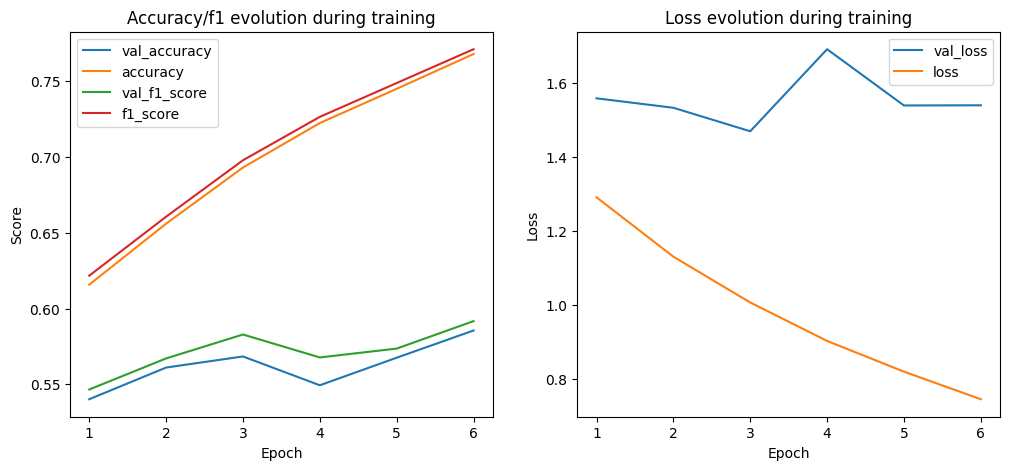

In [ ]:
history = get_full_training_history(model_id,training_history)
if history != None:
  save_training_history(model_id,history)
  #to avoid concat of same history when re-executing this cell
  training_history = None
  plot_training_history(history)

todo: comment

On va maintenant afficher le rapport de classification qui va nous donner une vision détaillée par classe des scores de prédiction.

In [ ]:

print(classification_report(y_test.astype("str"),test_pred_class))


              precision    recall  f1-score   support

          10       0.39      0.68      0.50       311
        1140       0.68      0.49      0.57       267
        1160       0.85      0.91      0.88       396
        1180       0.40      0.30      0.35        76
        1280       0.47      0.21      0.29       487
        1281       0.22      0.46      0.29       207
        1300       0.66      0.68      0.67       505
        1301       0.63      0.56      0.59        81
        1302       0.38      0.45      0.41       249
        1320       0.43      0.47      0.45       324
        1560       0.67      0.47      0.56       507
        1920       0.82      0.78      0.80       431
        1940       0.60      0.73      0.66        81
        2060       0.54      0.42      0.47       499
        2220       0.32      0.23      0.27        82
        2280       0.78      0.66      0.71       476
        2403       0.77      0.49      0.60       477
        2462       0.70    

todo: comment

Affichons la matrice de confusion sous forme de heatmap pour plus de lisibilité.

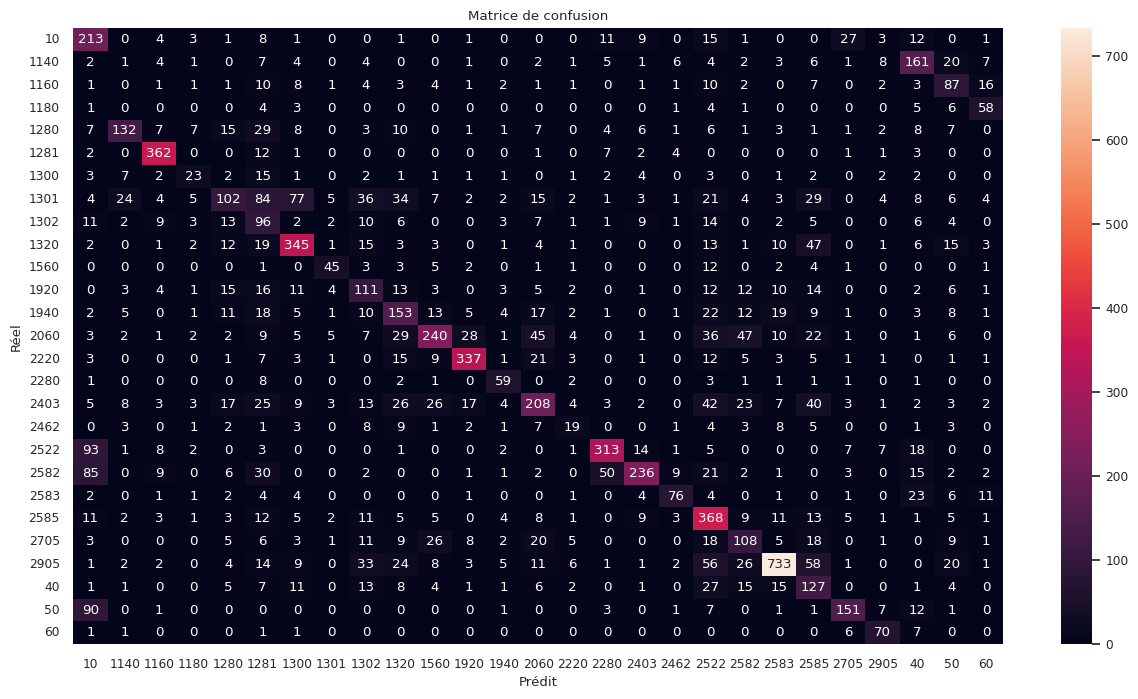

In [ ]:
cm = pd.crosstab(y_test,test_pred_class,rownames=["réel"],colnames=["prédit"])
plot_confusion_matrix(np.array(cm))



todo: comment

## Résumé

Nous avons atteint la fin de l'évaluation de cette modélisation. Affichons le rapport du modèle

In [ ]:
reporting_df.loc[model_id].T

model_name                                                          Modèle 1.1.7
dataset_source                 output/data-preprocessing-resampling/df_{train...
dataset_resampled                                                           True
image_dataset_source             output/data-preprocessing-images/images_pre.zip
image_dataset_zoomed                                                        True
train_size                                                               87652.0
image_size                                                                 224.0
image_color_rgb                                                             True
batch_size                                                                  32.0
image_data_generator_params    {'rescale': 0.00392156862745098, 'preprocessin...
start_lr                                                                  0.0001
last_lr                                                                   0.0001
optimizer                   

# Comparaison des modélisations de la stratégie 1

On va maintenant pouvoir comparer les rapports des 3 modélisations. Affichons leur rapport côte à côte

In [ ]:
reporting_df.loc[[111,112,113]].T

model_id,111,112,113
model_name,Modèle 1.1.1,Modèle 1.1.2,Modèle 1.1.3
dataset_source,output/data-exploration/X_train_pre.csv,output/data-preprocessing-images/df_pre.zip,output/data-preprocessing-resampling/df_{train...
dataset_resampled,False,False,True
image_dataset_source,data/images.zip,output/data-preprocessing-images/images_pre.zip,output/data-preprocessing-images/images_pre.zip
image_dataset_zoomed,False,True,True
train_size,8491.0,8491.0,8491.0
image_size,128.0,128.0,128.0
image_color_rgb,True,True,True
batch_size,32.0,32.0,32.0
image_data_generator_params,"{'rescale': 0.00392156862745098, 'rotation_ran...","{'rescale': 0.00392156862745098, 'rotation_ran...","{'rescale': 0.00392156862745098, 'rotation_ran..."


todo: comment

# Comparaison de tous les modèles du notebook

Comparons maintenant tous les modèles du notebooks.

In [ ]:
cols = ["model_name","dataset_resampled","image_dataset_zoomed",
        "train_size","image_size","batch_size","test_f1_score","test_accuracy"]
reporting_df = load_reporting_df()
reporting_df.loc[[111,112,113, 114, 115,117, 118],cols].T

model_id,111,112,113,114,115,117,118
model_name,Modèle 1.1.1,Modèle 1.1.2,Modèle 1.1.3,Modèle 1.1.4,Modèle 1.1.5,Modèle 1.1.7,Modèle 1.1.8
dataset_resampled,True,True,True,True,True,True,True
image_dataset_zoomed,True,True,True,True,True,True,True
train_size,21913.0,32869.0,27391.0,87652.0,87652.0,87652.0,87652.0
image_size,224.0,224.0,224.0,224.0,224.0,224.0,224.0
batch_size,64.0,32.0,64.0,64.0,64.0,32.0,32.0
test_f1_score,0.416277,0.153432,0.290177,0.344968,0.447567,0.585254,0.569055
test_accuracy,0.416277,0.153432,0.290177,0.344968,0.447567,0.585254,0.569055


todo: comment

# Conclusion

Todo